In [1]:
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy.constants as const
import jax.numpy as jnp
import jax
import jax.random as random
from copy import deepcopy
import time


In [2]:
#Some lenstronomy imports
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# # import lens model solver with 4 image positions constrains
# from lenstronomy.LensModel.Solver.solver4point import Solver4Point


In [150]:
# from helens import LensEquationSolver
import pandas as pd
from collections import OrderedDict
from functools import partial
from herculens.Util import param_util, plot_util
# from herculens.Util import param_util
import functools
import herculens as hcl
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
import jax
jax.config.update("jax_enable_x64", True)

In [4]:
key = random.PRNGKey(42)
key

Array([ 0, 42], dtype=uint32)

In [5]:
# probabilistic model and variational inference
import numpyro
import numpyro.distributions as dist
from numpyro import infer
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal
# import numpyro.constraints as constraints


# #Helens
# from helens import LensEquationSolver

In [6]:
import dynesty
from dynesty import plotting as dyplot
import corner 
import matplotlib.pyplot as plt

In [7]:
# Load JAX cosmology functions from the separate module
from jaxcosmo import JAXCosmology 
from astropy.cosmology import FlatLambdaCDM

import lensimage_gw

In [8]:
# Create JAX cosmology instance with the same parameters
jax_cosmo = JAXCosmology(H0=67.3, Om0=0.316)
astropy_cosmo = FlatLambdaCDM(H0=67.3, Om0=0.316)
print("JAX Cosmology Functions Loaded!")
print(f"Parameters: H0 = {jax_cosmo.H0} km/s/Mpc, Om0 = {jax_cosmo.Om0}, Ode0 = {jax_cosmo.Ode0}")
print(f"Hubble distance: {jax_cosmo.hubble_distance:.2f} Mpc")
print(f"Astropy Cosmology: H0 = {astropy_cosmo.H0} km/s/Mpc, Om0 = {astropy_cosmo.Om0}, Ode0 = {astropy_cosmo.Ode0}")
print(f"Hubble distance: {astropy_cosmo.hubble_distance:.2f} Mpc")

JAX Cosmology Functions Loaded!
Parameters: H0 = 67.3 km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc
Astropy Cosmology: H0 = 67.3 km / (Mpc s) km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc Mpc


In [9]:
# # JAX-based cosmology functions that match Astropy exactly
# import jax.numpy as jnp
# from jax import jit, vmap
# from jax.scipy.integrate import trapezoid

# # Define JAX cosmology functions as standalone functions (not methods)
# # This avoids issues with JIT compilation and class instances

# @jit
# def E_func(z, Om0, Ode0, Ok0):
#     """Dimensionless Hubble parameter E(z) = H(z)/H0."""
#     return jnp.sqrt(Om0 * (1 + z)**3 + Ode0 + Ok0 * (1 + z)**2)

# @jit
# def inv_E_func(z, Om0, Ode0, Ok0):
#     """Inverse of dimensionless Hubble parameter 1/E(z)."""
#     return 1.0 / E_func(z, Om0, Ode0, Ok0)

# @jit
# def comoving_distance_single(z, hubble_distance, Om0, Ode0, Ok0):
#     """Comoving distance to redshift z for a single redshift value."""
#     # Handle zero or negative redshift
#     z = jnp.maximum(z, 0.0)
    
#     # Create integration grid
#     n_points = 1000
#     z_grid = jnp.linspace(0.0, z, n_points)
#     integrand = inv_E_func(z_grid, Om0, Ode0, Ok0)
    
#     # Integrate using trapezoidal rule
#     integral_result = trapezoid(integrand, z_grid)
    
#     return hubble_distance * integral_result

# class JAXCosmology:
#     """
#     JAX-based cosmology class that matches Astropy's FlatLambdaCDM implementation.
#     Uses numerical integration for exact results.
#     """
    
#     def __init__(self, H0=70.0, Om0=0.3, Ode0=None):
#         """
#         Initialize cosmology parameters.
        
#         Parameters:
#         -----------
#         H0 : float
#             Hubble constant in km/s/Mpc
#         Om0 : float  
#             Matter density parameter at z=0
#         Ode0 : float, optional
#             Dark energy density parameter. If None, assumes flat universe (Ode0 = 1 - Om0)
#         """
#         self.H0 = H0
#         self.Om0 = Om0
#         self.Ode0 = 1.0 - Om0 if Ode0 is None else Ode0
#         self.Ok0 = 1.0 - self.Om0 - self.Ode0  # Curvature parameter
        
#         # Hubble distance in Mpc
#         self.hubble_distance = 299792.458 / H0  # c/H0 in Mpc
        
#         # Create vectorized version of comoving distance function
#         self._comoving_distance_vmap = vmap(
#             lambda z: comoving_distance_single(z, self.hubble_distance, self.Om0, self.Ode0, self.Ok0)
#         )
        
#     def E(self, z):
#         """
#         Dimensionless Hubble parameter E(z) = H(z)/H0.
        
#         Parameters:
#         -----------
#         z : float or array
#             Redshift
            
#         Returns:
#         --------
#         float or array : E(z)
#         """
#         return E_func(z, self.Om0, self.Ode0, self.Ok0)
    
#     def inv_E(self, z):
#         """
#         Inverse of dimensionless Hubble parameter 1/E(z).
#         This is the integrand for comoving distance.
#         """
#         return inv_E_func(z, self.Om0, self.Ode0, self.Ok0)
    
#     def comoving_distance(self, z):
#         """
#         Comoving distance to redshift z. Handles both single values and arrays.
        
#         Parameters:
#         -----------
#         z : float or array
#             Redshift(s)
            
#         Returns:
#         --------
#         float or array : Comoving distance(s) in Mpc
#         """
#         z = jnp.asarray(z)
        
#         # Handle single value
#         if z.ndim == 0:
#             return comoving_distance_single(z, self.hubble_distance, self.Om0, self.Ode0, self.Ok0)
        
#         # Handle array using vmap
#         return self._comoving_distance_vmap(z)
    
#     def luminosity_distance(self, z):
#         """
#         Luminosity distance to redshift z.
        
#         Parameters:
#         -----------
#         z : float or array
#             Redshift(s)
            
#         Returns:
#         --------
#         float or array : Luminosity distance(s) in Mpc
#         """
#         dc = self.comoving_distance(z)
#         z = jnp.asarray(z)
#         return dc * (1 + z)
    
#     def angular_diameter_distance(self, z):
#         """
#         Angular diameter distance to redshift z.
        
#         Parameters:
#         -----------
#         z : float or array
#             Redshift(s)
            
#         Returns:
#         --------
#         float or array : Angular diameter distance(s) in Mpc
#         """
#         dc = self.comoving_distance(z)
#         z = jnp.asarray(z)
#         return dc / (1 + z)
    
#     def angular_diameter_distance_z1z2(self, z1, z2):
#         """
#         Angular diameter distance between two redshifts.
        
#         Parameters:
#         -----------
#         z1 : float
#             Lower redshift
#         z2 : float
#             Higher redshift (z2 > z1)
            
#         Returns:
#         --------
#         float : Angular diameter distance between z1 and z2 in Mpc
#         """
#         # if z1 >= z2:
#         #     return 0.0
            
#         dc1 = self.comoving_distance(z1)
#         dc2 = self.comoving_distance(z2)
        
#         return (dc2 - dc1) / (1 + z2)
    
#     def time_delay_distance(self, z_lens, z_source):
#         """
#         Time delay distance for gravitational lensing.
        
#         Parameters:
#         -----------
#         z_lens : float
#             Lens redshift
#         z_source : float
#             Source redshift
            
#         Returns:
#         --------
#         float : Time delay distance in Mpc
#         """
#         # if z_lens >= z_source:
#         #     return 0.0
            
#         Dd = self.angular_diameter_distance(z_lens)
#         Ds = self.angular_diameter_distance(z_source)
#         Dds = self.angular_diameter_distance_z1z2(z_lens, z_source)
        
#         return (1 + z_lens) * Dd * Ds / Dds

# # Create JAX cosmology instance with the same parameters
# jax_cosmo = JAXCosmology(H0=67.3, Om0=0.316)
# astropy_cosmo = FlatLambdaCDM(H0=67.3, Om0=0.316)
# print("JAX Cosmology Functions Created!")
# print(f"Parameters: H0 = {jax_cosmo.H0} km/s/Mpc, Om0 = {jax_cosmo.Om0}, Ode0 = {jax_cosmo.Ode0}")
# print(f"Hubble distance: {jax_cosmo.hubble_distance:.2f} Mpc")
# print(f"Astropy Cosmology: H0 = {astropy_cosmo.H0} km/s/Mpc, Om0 = {astropy_cosmo.Om0}, Ode0 = {astropy_cosmo.Ode0}")
# print(f"Hubble distance: {astropy_cosmo.hubble_distance:.2f} Mpc")


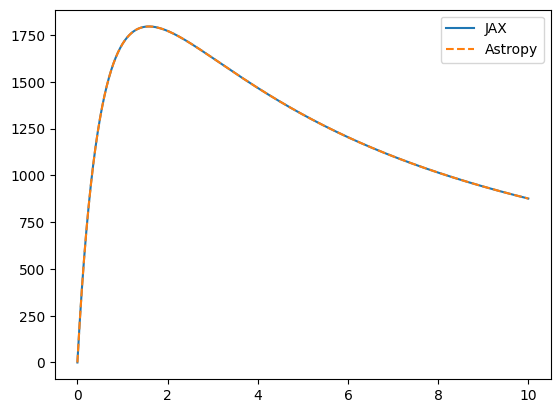

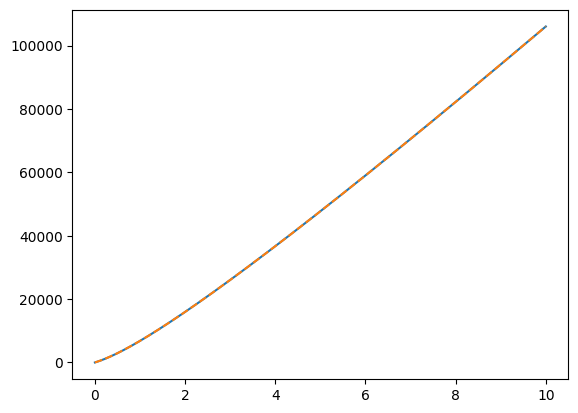

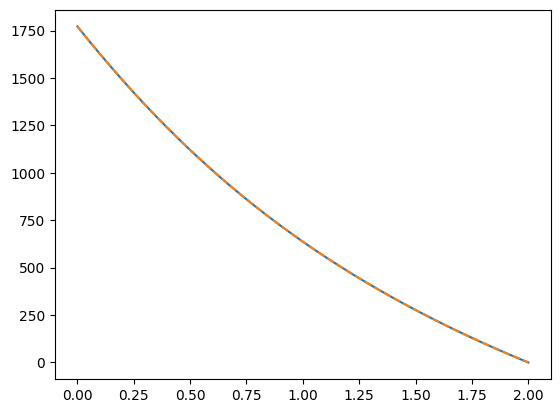

In [10]:
#compare the angular diameter distance from astropy and jax
zarr = jnp.linspace(0, 10, 1000)
d_ang_jax = jax_cosmo.angular_diameter_distance(zarr)
d_ang_astropy = astropy_cosmo.angular_diameter_distance(zarr)

plt.plot(zarr, d_ang_jax, label='JAX')
plt.plot(zarr, d_ang_astropy,'--', label='Astropy')
plt.legend()
plt.show()

#compare the luminosity distance from astropy and jax
zarr = jnp.linspace(0, 10, 1000)
d_lum_jax = jax_cosmo.luminosity_distance(zarr)
d_lum_astropy = astropy_cosmo.luminosity_distance(zarr)

plt.plot(zarr, d_lum_jax, label='JAX')
plt.plot(zarr, d_lum_astropy,'--', label='Astropy')
plt.show()

#Compare angular diameter distance z1z2 from astropy and jax
z1 = jnp.linspace(0, 2, 1000)
z2 = 2.0
d_ang_jax = jax_cosmo.angular_diameter_distance_z1z2(z1, z2)
d_ang_astropy = astropy_cosmo.angular_diameter_distance_z1z2(z1, z2)
plt.plot(z1, d_ang_jax, label='JAX')
plt.plot(z1, d_ang_astropy,'--', label='Astropy')
plt.show()



In [11]:
# def get_time_delay_distance(z_lens, z_source, cosmo = cosmo):
#     ''' Returns the time delay distance in Mpc between a lens at redshift z_lens and a source at redshift z_source '''
#     Dds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)
#     Ds = cosmo.angular_diameter_distance(z_source)
#     Dd = cosmo.angular_diameter_distance(z_lens)
#     D_dt = (1+z_lens)*Ds*Dd/Dds
#     return D_dt # In units of Mpc

# arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 

In [12]:
# # Define the pixel grid
# npix = 80  # number of pixel on a side
# pix_scl = 0.08  # pixel size in arcsec
# half_size = npix * pix_scl / 2
# ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
# transform_pix2angle = pix_scl * jnp.eye(2)  # transformation matrix pixel <-> angle
# kwargs_pixel = {'nx': npix, 'ny': npix,
#                 'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
#                 'transform_pix2angle': transform_pix2angle}

# # create the PixelGrid class
# pixel_grid = hcl.PixelGrid(**kwargs_pixel)
# xgrid, ygrid = pixel_grid.pixel_coordinates
# extent = pixel_grid.extent

# print(f"image size : ({npix}, {npix}) pixels")
# print(f"pixel size : {pix_scl} arcsec")
# print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
# print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

In [13]:
arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 

In [14]:
#Setup the lens
zs_true = 2.0; zl_true = 0.5
phi_true = 8.0 # position angle, here in degree
q_true = 0.75 # axis ratio, b/a
e1_true, e2_true = param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q_true) # conversion to ellipticities
print(e1_true, e2_true)
theta_E_true = 5.0 # Einstein radius
y0true = 0.3
y1true = 0.2
# y_true = jnp.array([y0true, y1true])
cx0_true, cy0_true = 0.0, 0.0 # position of the lens

lens_mass_model  = MassModel(["SIE", 'SHEAR'])
# lens_mass_model_input = hcl.MassModel([hcl.SIE(), hcl.Shear()])


#SIS for validation and first pass
# kwargs_lens_true_sis = [
#     {'theta_E': theta_E_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIS
# ]
kwargs_lens_true_sie = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]

# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.0001
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * jnp.pi / 180, gamma_ext)
print(gamma1, gamma2)
kwargs_lens_true_sie_shear = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]

0.13732309941975984 0.03937676511671417
-3.090169943749473e-05 9.510565162951537e-05


In [15]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver


# Define classes for lenstronomy
lensModel = LensModel(lens_model_list=['SIE','SHEAR'],z_lens = zl_true, z_source=zs_true)
solver = LensEquationSolver(lensModel)

# Convert JAX arrays to regular Python floats for lenstronomy compatibility
kwargs_lens_true_sie_shear_fixed = [
    {
        'theta_E': float(theta_E_true), 
        'e1': float(e1_true), 
        'e2': float(e2_true), 
        'center_x': float(cx0_true), 
        'center_y': float(cy0_true)
    },
    {
        'gamma1': float(gamma1),
        'gamma2': float(gamma2),
        'ra_0': float(0.0),
        'dec_0': float(0.0)
    }
]

# Convert source positions to regular Python floats
y0true_float = float(y0true)
y1true_float = float(y1true)

print("Fixed lens parameters for lenstronomy:")
print(f"  theta_E: {kwargs_lens_true_sie_shear_fixed[0]['theta_E']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['theta_E'])})")
print(f"  e1: {kwargs_lens_true_sie_shear_fixed[0]['e1']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e1'])})")
print(f"  e2: {kwargs_lens_true_sie_shear_fixed[0]['e2']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e2'])})")
print(f"  source position: ({y0true_float}, {y1true_float})")

# compute image position of full model (with numerical options attached)
x_image_true, y_image_true = solver.image_position_from_source(
    kwargs_lens=kwargs_lens_true_sie_shear_fixed,
    sourcePos_x=y0true_float, 
    sourcePos_y=y1true_float,
    min_distance=0.01, 
    search_window=15, 
    precision_limit=10**(-10), 
    num_iter_max=1200,
    solver='lenstronomy'
)
print('image positions (x coordinates): ', x_image_true)
print('image positions (y coordinates): ', y_image_true)

# check solver precision by ray-tracing the image positions back into the source plane
x_source_new, y_source_new = lensModel.ray_shooting(x_image_true, y_image_true, kwargs_lens_true_sie_shear_fixed)
print('x_source_new:',x_source_new)
print('y_source_new:',y_source_new)
print("the relative precision of the image positions are: ", x_source_new - y0true_float)



Fixed lens parameters for lenstronomy:
  theta_E: 5.0 (type: <class 'float'>)
  e1: 0.13732309941975984 (type: <class 'float'>)
  e2: 0.03937676511671417 (type: <class 'float'>)
  source position: (0.3, 0.2)


image positions (x coordinates):  [ 0.93983855  2.90057564  5.01972316 -4.25658029]
image positions (y coordinates):  [ 5.33193565 -4.22283481 -0.4382769  -1.10487159]
x_source_new: [0.3 0.3 0.3 0.3]
y_source_new: [0.2 0.2 0.2 0.2]
the relative precision of the image positions are:  [ 2.89895330e-11 -2.20640173e-12 -3.99619782e-11  4.04459799e-12]


Using fixed parameters for plotting:
  theta_E: 5.0 (type: <class 'float'>)
  source position: (0.3, 0.2)


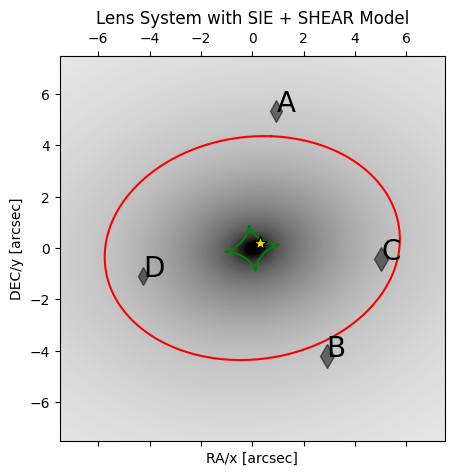

In [16]:
# Plot the lens system (FIXED VERSION)
from lenstronomy.Plots import lens_plot
import matplotlib.pyplot as plt

# Use the fixed parameters (converted to Python floats) for plotting
f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)

# Make sure we have the fixed parameters available
if 'kwargs_lens_true_sie_shear_fixed' not in locals():
    # Convert JAX arrays to regular Python floats for lenstronomy compatibility
    kwargs_lens_true_sie_fixed = [
        {
            'theta_E': float(theta_E_true), 
            'e1': float(e1_true), 
            'e2': float(e2_true), 
            'center_x': float(cx0_true), 
            'center_y': float(cy0_true)
        },
        {
            'gamma1': float(gamma1),
            'gamma2': float(gamma2),
            'ra_0': float(0.0),
            'dec_0': float(0.0)
        }
    ]
    y0true_float = float(y0true)
    y1true_float = float(y1true)

print("Using fixed parameters for plotting:")
print(f"  theta_E: {kwargs_lens_true_sie_shear_fixed[0]['theta_E']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['theta_E'])})")
print(f"  source position: ({y0true_float}, {y1true_float})")

lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens_true_sie_shear_fixed, 
                          sourcePos_x=y0true_float, sourcePos_y=y1true_float, 
                          point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False,
                         numPix=1000, deltaPix=0.015,cmap_string="gist_heat")

plt.title("Lens System with SIE + SHEAR Model")
plt.show()


## Set up EM observation

In [33]:
npix = 200  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * jnp.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (200, 200) pixels
pixel size : 0.08 arcsec
x range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec
y range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec


In [34]:
psf = hcl.PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pix_scl)

background_rms_simu = 1e-2
exposure_time_simu = 1e3
noise_simu = hcl.Noise(npix, npix, background_rms=background_rms_simu, exposure_time=exposure_time_simu)
noise = hcl.Noise(npix, npix, exposure_time=exposure_time_simu)  # we will sample background_rms

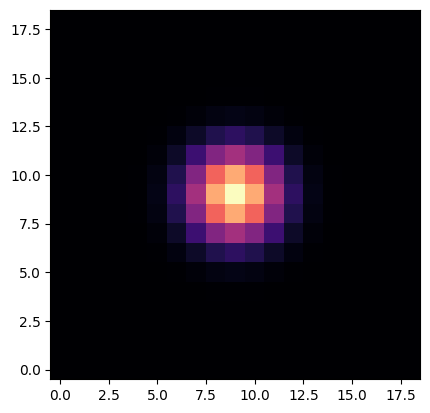

In [35]:
# Compute a Gaussian PSF kernel with given pixel scale, FWHM, and truncation (e.g. 6 * sigma)
kernel = psf.compute_gaussian_kernel(pix_scl, 0.3, 6)
plt.imshow(kernel, cmap='magma')

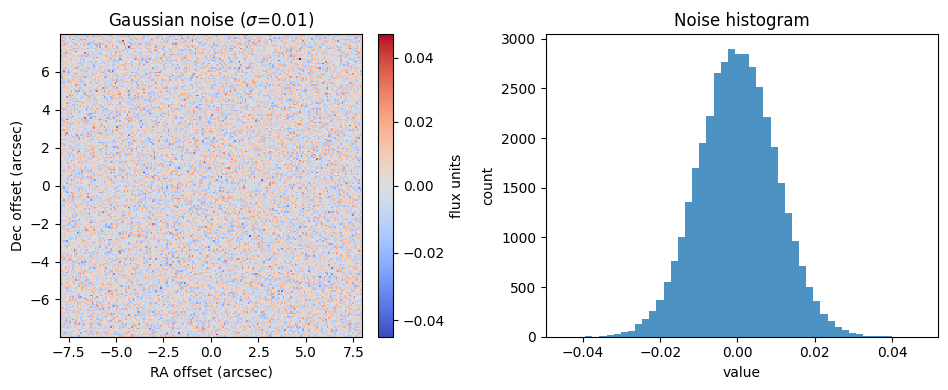

In [36]:
# Visualize background noise map (independent of `hcl.Noise` internals)
import numpy as np
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm


rng = np.random.default_rng(0)
noise_map = rng.normal(loc=0.0, scale=background_rms_simu, size=(npix, npix))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
im = ax.imshow(noise_map, origin='lower', cmap='coolwarm', norm=TwoSlopeNorm(0), extent=extent)
ax.set_title(rf"Gaussian noise ($\sigma$={background_rms_simu})")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='flux units')
ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')

ax = axes[1]
ax.hist(noise_map.ravel(), bins=50, color='tab:blue', alpha=0.8)
ax.set_title('Noise histogram')
ax.set_xlabel('value')
ax.set_ylabel('count')

plt.tight_layout()
plt.show()


In [37]:
# Lens light
lens_light_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}
]
#pprint(kwargs_lens_light_input)

# Source light
y1_em_true = 0.05
y2_em_true = 0.1
e1_em_s_true = 0.05
e2_em_s_true = 0.05 
source_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.5, 'n_sersic': 2., 'e1': e1_em_s_true, 'e2': e2_em_s_true, 'center_x': y1_em_true, 'center_y': y2_em_true}
]

In [38]:
# Generate a lensed image based on source and lens models (Mock EM data)
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise_simu,
                         lens_mass_model_class=lens_mass_model,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_true_sie_shear_fixed,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
SEED = 87651  # fixes the stochasticity
key = jax.random.PRNGKey(SEED)
key, key_sim = jax.random.split(key)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_sim)

In [39]:
# Plotting engine
plotter = hcl.Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

In [40]:
data.shape

(200, 200)

In [41]:
xx, yy = pixel_grid.pixel_coordinates

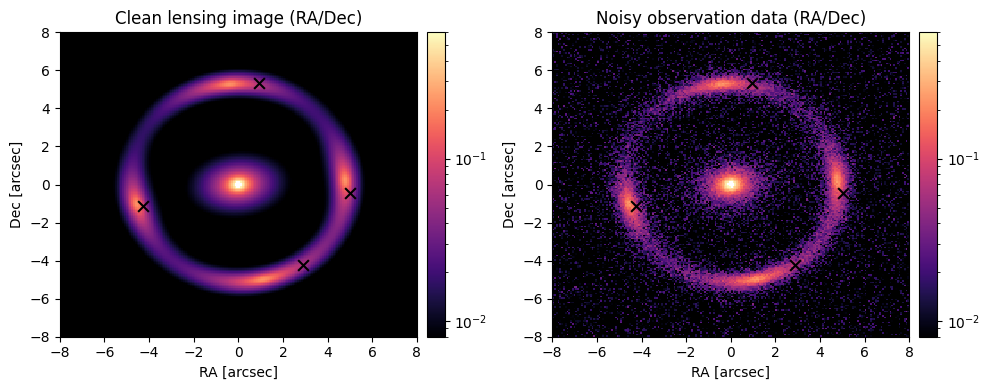

In [42]:
# visualize simulated products using the image grid xx and yy and scatter image positions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot clean image
img1 = ax1.pcolormesh(xx, yy, image, shading='auto', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image (RA/Dec)")
ax1.set_xlabel("RA [arcsec]")
ax1.set_ylabel("Dec [arcsec]")

# Scatter the true image positions
ax1.scatter(x_image_true, y_image_true, color='black', marker='x', s=60)
# ax1.legend()

# Plot noisy data
img2 = ax2.pcolormesh(xx, yy, data, shading='auto', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img2)
ax2.set_title("Noisy observation data (RA/Dec)")
ax2.set_xlabel("RA [arcsec]")
ax2.set_ylabel("Dec [arcsec]")

# Scatter the true image positions
ax2.scatter(x_image_true, y_image_true, color='black', marker='x', s=60)
# ax2.legend()

fig.tight_layout()
plt.show()

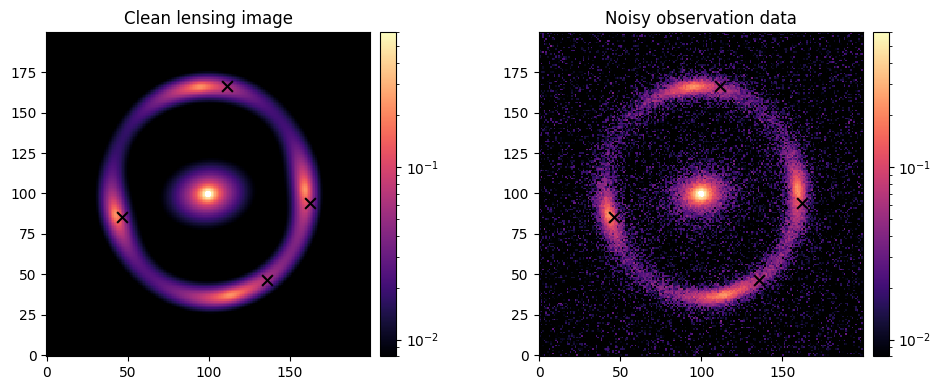

In [43]:
#Get pixel coordinate of gw images
x_pix_gw, y_pix_gw = pixel_grid.map_coord2pix(x_image_true, y_image_true)

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
ax1.scatter(x_pix_gw, y_pix_gw, color='black', marker='x', s=60, label='GW')
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
ax2.scatter(x_pix_gw, y_pix_gw, color='black', marker='x', s=60, label='GW')
fig.tight_layout()
plt.show()

In [44]:
kwargs_numerics_fit = {'supersampling_factor': 2}
lens_image = hcl.LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model),
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_fit)

In [45]:
tarrival_lt = lensModel.arrival_time(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
phi_lt = lensModel.fermat_potential(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
magnifications_lt = lensModel.magnification(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
print(phi_lt)
print(magnifications_lt)

print(tarrival_lt)
print(jnp.diff(tarrival_lt)) # in days

[-14.59051491 -13.0588558  -12.63044923  -9.60442232]
[ 5.46367268  8.66928312 -8.06563393 -3.26537798]
[-1255.59720402 -1123.78918267 -1086.92234911  -826.51543686]
[131.80802135  36.86683357 260.40691225]


In [46]:
# Create  a mock GW observation
# arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 
time_delay_distance_true = jax_cosmo.time_delay_distance(zl_true, zs_true) #with Mpc unit
print('Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]:', time_delay_distance_true)

x_image_true = jnp.array(x_image_true)
y_image_true = jnp.array(y_image_true)

lens_gw = lensimage_gw.LensImageGW(lens_mass_model)
data_GW = lens_gw.compute(x_image_true,y_image_true,kwargs_lens_true_sie_shear,time_delay_distance_true)

print(data_GW)

dL_true = jax_cosmo.luminosity_distance(zs_true)
magnifications_true = data_GW['mu']
dL_effectives_true = dL_true/jnp.sqrt(jnp.abs(magnifications_true))
time_delays_true = data_GW['time_delays_in_seconds']
gw_obs = {
    'time_delays': time_delays_true, 
    'dL_eff': dL_effectives_true
}

print(gw_obs)

Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]: 3088.8635805953318
{'beta_x': Array([0.3, 0.3, 0.3, 0.3], dtype=float64), 'beta_y': Array([0.2, 0.2, 0.2, 0.2], dtype=float64), 'psi': Array([27.96359333, 26.22108648, 23.97204131, 20.83697923], dtype=float64), 'mu': Array([ 5.4636646 ,  8.66926348, -8.06538814, -3.26536634], dtype=float64), 'phi_in_arcsecsq': Array([-14.59051491, -13.0588558 , -12.63044923,  -9.60442232], dtype=float64), 'Tstar_in_seconds': Array(7472713.02060066, dtype=float64), 'tarrivals_in_seconds': Array([-1.09030731e+08, -9.75850817e+07, -9.43837224e+07, -7.17710917e+07],      dtype=float64), 'tarrivals_days': Array([-1261.92975406, -1129.45696468, -1092.40419483,  -830.68393161],      dtype=float64), 'time_delays_in_seconds': Array([11445649.00293511,  3201359.31445333, 22612630.74202657], dtype=float64), 'time_delays_in_days': Array([132.47278939,  37.05276984, 261.72026322], dtype=float64)}
{'time_delays': Array([11445649.00293511,  3201359.31445333, 2261

In [47]:
# arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 
# arcsecond_to_radians = float(arcsecond_to_radians)
# arcsecond_to_radians 

In [48]:
# float(1*u.Mpc.to(u.m))

In [49]:
# const.c.value

In [50]:
# # Get the true GW observables
# #So to get dimensionless potential divide by einstein_rad^2
# arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 
# fermat_potential_true = lens_mass_model.fermat_potential(x_image_true,y_image_true,kwargs_lens_true_sie_shear)#/theta_E_true**2
# print('Fermat Potential (Herculens):', fermat_potential_true)
# print('Fermat Potential Difference:', jnp.diff(fermat_potential_true))
# print('_'*50)

# time_delay_distance_true = jax_cosmo.time_delay_distance(zl_true, zs_true) #with Mpc unit
# print('Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]:', time_delay_distance_true)
# Tstar_true = ((time_delay_distance_true*u.Mpc).to(u.m)/const.c)  * (arcsecond_to_radians)**2
# print('Tstar_true (D_dt*theta_E^2/c):', Tstar_true)

# arrival_times_true = Tstar_true*fermat_potential_true
# print('Arrival times:', arrival_times_true)
# print('_'*80)

# print('Arrival times (in days):', arrival_times_true.to(u.day))

# magnifications_true = lens_mass_model.magnification(x_image_true,y_image_true,kwargs_lens_true_sie_shear)
# print('Magnification (Herculens)', magnifications_true)

# print('_'*80)

# print('Sorting images according to their arrival times')
# idx_sort = jnp.argsort(arrival_times_true)
# x_image_true = x_image_true[idx_sort]; 
# y_image_true = y_image_true[idx_sort]; 
# image_pos_true = []
# for i in range(len(x_image_true)):
#     image_pos_true.append([x_image_true[i],y_image_true[i]])
# fermat_potential_true = fermat_potential_true[idx_sort]; 
# magnifications_true = magnifications_true[idx_sort]; 
# arrival_times_true = arrival_times_true[idx_sort]; 
# print('Sorted Arrival Times:', arrival_times_true.to(u.day))
# time_delays_true = jnp.diff(arrival_times_true)*u.s # Set time delays
# print('Time delay (difference between arrival time in order):', time_delays_true)
# print('_'*50)

# # Get the effective luminosity distances
# dL_true = jax_cosmo.luminosity_distance(zs_true)
# dL_effectives_true = dL_true/jnp.sqrt(jnp.abs(magnifications_true))
# print('True luminosity distance (in Mpc):', dL_true)

# print('\n' + '*'*40 + ' GW Observables ' + '*'*40)
# print('Time delays (in days):', time_delays_true.to(u.day))
# print('Effective dL:', dL_effectives_true)
# print('\n' + '*'*40 + ' GW Observables ' + '*'*40)


In [51]:
# c_m_per_s = const.c.value
# Mpc_to_m = 1*u.Mpc.to(u.m)

In [52]:
# time_delays_true

In [53]:
data.shape

(200, 200)

In [54]:
m = jnp.array([1,2,3,4,5,6])
er = jnp.array([0.01,0.2,0.3,0.4,0.5,0.6])
d = jnp.array([1,3,3,4,6,6])

In [55]:
jnp.sum(-0.5*(m-d)**2/er**2 + jnp.log(1/jnp.sqrt(2*jnp.pi*er**2)))


Array(-10.47478676, dtype=float64)

In [56]:
time_delays_true
dL_effectives_true

Array([6822.27176334, 5416.01589014, 5615.11163248, 8824.80412962],      dtype=float64)

In [57]:
dist.Independent(dist.Normal(m, er), 1).log_prob(d)

Array(-10.47478676, dtype=float64)

In [58]:
numpyro.sample('obs', dist.Independent(dist.Normal(m, er), 1), obs=d)

Array([1, 3, 3, 4, 6, 6], dtype=int64)

In [80]:
class ProbModel(hcl.NumpyroModel):
    def __init__(self, n_images=4, gw_observations=None, em_observations=None):
    
        self.n_images = n_images
        self.gw_observations = gw_observations or {}
        self.em_observations = em_observations or {}
        super().__init__()
        
        # Store likelihood values
        self.em_loglike = 0.0
        self.gw_loglike = 0.0
        self.prior_loglike = 0.0
        self.combined_loglike = 0.0

    def model(self):
        # Track prior contributions
        prior_loglike = 0.0
        zs = numpyro.sample('zs', dist.Uniform(1.0, 10.0))
        prior_loglike += dist.Uniform(1.0, 10.0).log_prob(zs)
        
        zl = numpyro.sample('zl', dist.Uniform(0.0, zs-0.0001))
        prior_loglike += dist.Uniform(0.0, zs-0.0001).log_prob(zl)
        
        # Image positions
        image_positions = []
        x_pos_array = []
        y_pos_array = []
        for i in range(self.n_images):
            # X positions
            x_pos = numpyro.sample(f'image_x{i+1}', dist.Uniform(-10, 10))
            prior_loglike += dist.Uniform(-10, 10).log_prob(x_pos)
            
            # Y positions
            y_pos = numpyro.sample(f'image_y{i+1}', dist.Uniform(-10, 10))
            prior_loglike += dist.Uniform(-10, 10).log_prob(y_pos)
            
            image_positions.append((x_pos, y_pos))
            x_pos_array.append(x_pos)
            y_pos_array.append(y_pos)
        
        x_pos_array = jnp.array(x_pos_array)
        y_pos_array = jnp.array(y_pos_array)
        # Parameters of the source
        source_amp = numpyro.sample('source_amp', dist.LogNormal(4.0, 0.2))
        prior_loglike += dist.LogNormal(1.0, 0.1).log_prob(source_amp)
        
        source_R_sersic = numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.5, 0.1, low=0.05))
        prior_loglike += dist.TruncatedNormal(0.5, 0.1, low=0.05).log_prob(source_R_sersic)
        
        source_n = numpyro.sample('source_n', dist.Uniform(1., 3.))
        prior_loglike += dist.Uniform(1., 3.).log_prob(source_n)
        
        source_e1 = numpyro.sample('source_e1', dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3).log_prob(source_e1)
        
        source_e2 = numpyro.sample('source_e2', dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3).log_prob(source_e2)
        
        source_center_x = numpyro.sample('source_center_x', dist.Normal(0.05, 0.02))
        prior_loglike += dist.Normal(0.05, 0.02).log_prob(source_center_x)
        
        source_center_y = numpyro.sample('source_center_y', dist.Normal(0.1, 0.02))
        prior_loglike += dist.Normal(0.1, 0.02).log_prob(source_center_y)
        
        prior_source = [
            {'amp': source_amp,
            'R_sersic': source_R_sersic, 
            'n_sersic': source_n, 
            'e1': source_e1,
            'e2': source_e2,
            'center_x': source_center_x, 
            'center_y': source_center_y}
            ]

        # Parameters of the lens light that are used for the lens mass
        cx = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
        prior_loglike += dist.Normal(0., pix_scl/2.).log_prob(cx)
        
        cy = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))
        prior_loglike += dist.Normal(0., pix_scl/2.).log_prob(cy)
        
        e1 = numpyro.sample('light_e1', dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3).log_prob(e1)
        
        e2 = numpyro.sample('light_e2', dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3).log_prob(e2)

        # Parameters of the lens light, with center relative the lens mass
        light_amp = numpyro.sample('light_amp', dist.LogNormal(2., 0.5))
        prior_loglike += dist.LogNormal(2., 0.5).log_prob(light_amp)
        
        light_R_sersic = numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.5))
        prior_loglike += dist.Normal(1.0, 0.5).log_prob(light_R_sersic)
        
        light_n = numpyro.sample('light_n', dist.Uniform(2., 5.))
        prior_loglike += dist.Uniform(2., 5.).log_prob(light_n)
        
        prior_lens_light = [
            {'amp': light_amp, 
            'R_sersic': light_R_sersic, 
            'n_sersic': light_n, 
            'e1': e1,
            'e2': e2,
            'center_x': cx, 
            'center_y': cy}
            ]

        # Lens mass parameters
        lens_theta_E = numpyro.sample('lens_theta_E', dist.Normal(1.5, 0.1))
        prior_loglike += dist.Normal(1.5, 0.1).log_prob(lens_theta_E)
        
        lens_e1 = numpyro.sample('lens_e1', dist.Normal(e1, 0.05))
        prior_loglike += dist.Normal(e1, 0.005).log_prob(lens_e1)
        
        lens_e2 = numpyro.sample('lens_e2', dist.Normal(e2, 0.05))
        prior_loglike += dist.Normal(e2, 0.005).log_prob(lens_e2)
        
        lens_center_x = numpyro.sample('lens_center_x', dist.Normal(cx, 0.05))
        prior_loglike += dist.Normal(cx, 0.005).log_prob(lens_center_x)
        
        lens_center_y = numpyro.sample('lens_center_y', dist.Normal(cy, 0.05))
        prior_loglike += dist.Normal(cy, 0.005).log_prob(lens_center_y)
        
        # External shear parameters
        gamma1 = numpyro.sample('lens_gamma1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3).log_prob(gamma1)
        
        gamma2 = numpyro.sample('lens_gamma2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3).log_prob(gamma2)
        
        sigma_bkg = numpyro.sample('noise_sigma_bkg', dist.Uniform(low=1e-3, high=1e-1))
        prior_loglike += dist.Uniform(low=1e-3, high=1e-1).log_prob(sigma_bkg)

        prior_lens = [
            {'theta_E': lens_theta_E,
            'e1': lens_e1,
            'e2': lens_e2,
            'center_x': lens_center_x, 
            'center_y': lens_center_y},
            # external shear, with fixed origin
            {'gamma1': gamma1, 
            'gamma2': gamma2, 
            'ra_0': 0.0, 'dec_0': 0.0}
            ]        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        

        if self.em_observations:
            # generates the model image
            model_image = lens_image.model(**model_params)
            data = self.em_observations['data']
            # estimate the error per pixel
            
            
            model_var = noise.C_D_model(model_image, background_rms=sigma_bkg)
            model_std = jnp.sqrt(model_var)

            # EM likelihood (already included in the sample statement below)
            em_loglike = dist.Independent(dist.Normal(model_image, model_std), 2).log_prob(data)

            self.em_loglike = em_loglike
            # jax.debug.print("EM log-likelihood: {em_loglike}", em_loglike=em_loglike)
            # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
            numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
        else:
            self.em_loglike = 0.0

        if self.gw_observations:
            D_dt_model = jax_cosmo.time_delay_distance(zl,zs)
            dL_model = jax_cosmo.luminosity_distance(zs)
            model_gw = lens_gw.compute(x_pos_array,y_pos_array,prior_lens,D_dt_model)
            beta_x = model_gw['beta_x']
            beta_y = model_gw['beta_y']
            betx_x_diff = jnp.diff(beta_x)
            bety_y_diff = jnp.diff(beta_y)
            zeros = jnp.zeros_like(betx_x_diff) 
            ones = jnp.ones_like(betx_x_diff)

            model_time_delays = model_gw['time_delays_in_seconds']
            model_magnifications = model_gw['mu']
            model_dL_eff = dL_model/jnp.sqrt(jnp.abs(model_magnifications))

            sigma_td = 0.05 * time_delays_true
            sigma_dL_eff = 0.05 * dL_effectives_true
            epsilon = 0.005*ones

            numpyro.sample('tdelays_obs', dist.Independent(dist.Normal(model_time_delays, sigma_td), 1), obs=time_delays_true)
            numpyro.sample('dL_eff_obs', dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1), obs=dL_effectives_true)
            numpyro.sample('betx_x_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=betx_x_diff)
            numpyro.sample('bety_y_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=bety_y_diff)

            loglike_td = dist.Independent(dist.Normal(model_time_delays, sigma_td), 1).log_prob(time_delays_true)
            loglike_dL_eff = dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1).log_prob(dL_effectives_true)
            loglike_betx_x_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(betx_x_diff)
            loglike_bety_y_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(bety_y_diff)

            loglike_gw = loglike_td + loglike_dL_eff + loglike_betx_x_diff + loglike_bety_y_diff
            # gw_logprob = self._compute_gw_logprob(zl,zs,image_positions, prior_lens)
            # This line adds the computed GW log-likelihood (gw_loglike) to the model's total log-probability.
            # It effectively incorporates the GW likelihood as an unnormalized factor in the probabilistic model.
            # numpyro.factor('gw_likelihood', gw_logprob)
            self.gw_loglike = loglike_gw
            # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=loglike_gw)
        else:
            self.gw_loglike = 0.0
        
        self.prior_loglike = prior_loglike
        # jax.debug.print("Prior log-likelihood: {prior_loglike}", prior_loglike=self.prior_loglike)
        # jax.debug.print("EM log-likelihood: {em_loglike}", em_loglike=self.em_loglike)
        # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=self.gw_loglike)
        
        # Combined likelihood (prior + EM + GW)
        
        combined_loglike = self.prior_loglike + self.em_loglike + self.gw_loglike
        self.combined_loglike = combined_loglike
        # jax.debug.print("Combined log-likelihood: {combined_loglike}", combined_loglike=self.combined_loglike)


    def _compute_gw_logprob(self,zl,zs,image_positions, lens_params):#zs, zl, image_positions, lens_params, kappa_ext):
    
        # Convert image positions to arrays
        x_images = jnp.array([pos[0] for pos in image_positions])
        y_images = jnp.array([pos[1] for pos in image_positions])
        
        # Create lens mass model
        lens_mass_model = hcl.MassModel(["SIE","SHEAR"])
        
        # Ray shooting to get source positions
        source_positions = []
        for i in range(self.n_images):
            # Ray shoot from image to source
            beta_x, beta_y = lens_mass_model.ray_shooting(
                x_images[i], y_images[i], lens_params
            )
            source_positions.append((beta_x, beta_y))
        
        # Check consistency: all images should map to same source
        source_x = jnp.array([pos[0] for pos in source_positions])
        source_y = jnp.array([pos[1] for pos in source_positions])
    
        # # Consistency penalty (sum of squared deviations)
        epsilon = 0.005
        consistency_penalty = -0.5*(jnp.sum((jnp.diff(source_x)**2) / (epsilon**2) + (jnp.diff(source_y)**2) / (epsilon**2)))

        # Calculate Fermat potential for time delays
        fermat_potentials = []
        for i in range(self.n_images):
            phi = lens_mass_model.fermat_potential(
                x_images[i], y_images[i], lens_params
            )
            fermat_potentials.append(phi)
        
        fermat_potentials = jnp.array(fermat_potentials)#/lens_params[0]['theta_E']**2

        # Calculate magnifications
        magnifications = []
        for i in range(self.n_images):
            mu = lens_mass_model.magnification(
                x_images[i], y_images[i], lens_params
            )
            magnifications.append(mu)
        
        magnifications = jnp.array(magnifications)
        dL = jax_cosmo.luminosity_distance(zs) #using jax cosmology
        Ddt = jax_cosmo.time_delay_distance(zl,zs)#using jax cosmology
        # Calculate Tstar
        Ddt_meters = Ddt * Mpc_to_m
        Tstar = (Ddt_meters / c_m_per_s)* (arcsecond_to_radians)**2
        # Calculate arrival times (proportional to Fermat potential)
        arrival_times = Tstar * fermat_potentials
        
        # Calculate effective luminosity distances
        dL_eff = dL / jnp.sqrt(jnp.abs(magnifications))
        
        idx = jnp.argsort(arrival_times)
    
        sorted_arrival_times = arrival_times[idx]#*(1-kappa_ext)
        sorted_magnifications = magnifications[idx]#/(1-kappa_ext)**2
        sorted_dL_eff = dL_eff[idx]#*(1-kappa_ext)
        # Compare with observations
        sigma_td = 0.05 * time_delays_true.value
        sigma_dL_eff = 0.05 * dL_effectives_true
        if 'time_delays' in self.gw_observations:
            computed_delays = jnp.diff(sorted_arrival_times)  # Time delays between images
            obs_delays = jnp.array(self.gw_observations['time_delays'])
            diffsq_t = (computed_delays - obs_delays)**2
            err_t_sq = sigma_td**2
            time_likelihood = -0.5 * jnp.sum(diffsq_t/err_t_sq)
        else:
            time_likelihood = 0.0

        if 'magnifications' in self.gw_observations:
            obs_mags = jnp.array(self.gw_observations['magnifications'])
            mag_likelihood = -0.5 * jnp.sum((sorted_magnifications - obs_mags)**2)
        else:
            mag_likelihood = 0.0
            
        if 'dL_eff' in self.gw_observations:
            obs_dL_eff = jnp.array(self.gw_observations['dL_eff'])
            diffsq_dl = (sorted_dL_eff - obs_dL_eff)**2
            err_dl_sq = sigma_dL_eff**2
            dL_likelihood = -0.5 * jnp.sum(diffsq_dl/err_dl_sq)
        else:
            dL_likelihood = 0.0
        
        # Total likelihood with consistency penalty
        total_likelihood = (time_likelihood + dL_likelihood + consistency_penalty)
        
        return total_likelihood

    
    def params2kwargs(self, params):
        # functions that takes the flatten dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2'],
        'center_x': params['lens_center_x'],
        'center_y': params['lens_center_y']},
        {'gamma1': params['lens_gamma1'],
        'gamma2': params['lens_gamma2'],
        'ra_0': 0.0,
        'dec_0': 0.0}],
        'kwargs_source': [{'amp': params['source_amp'],
        'R_sersic': params['source_R_sersic'],
        'n_sersic': params['source_n'],
        'e1': params['source_e1'],
        'e2': params['source_e2'],
        'center_x': params['source_center_x'],
        'center_y': params['source_center_y']}],
        'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n'],
        'e1': params['light_e1'],
        'e2': params['light_e2'],
        'center_x': params['light_center_x'],
        'center_y': params['light_center_y']}],
        'zs': params['zs'],
        'zl': params['zl'],
        'image_positions': [
                (params.get(f'image_x{i+1}', 0.0),
                params.get(f'image_y{i+1}', 0.0))
                for i in range(self.n_images)
            ]
        }
        return kw
    
    def get_likelihoods(self):
        """Return the computed likelihood values"""
        # jax.debug.print("Getting likelihoods")
        # jax.debug.print(self.prior_loglike)
        # jax.debug.print(self.em_loglike)
        # jax.debug.print(self.gw_loglike)
        # jax.debug.print(self.combined_loglike)
        return {
            'prior_loglike': self.prior_loglike,
            'em_loglike': self.em_loglike,
            'gw_loglike': self.gw_loglike, 
            'combined_loglike': self.combined_loglike
        }

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 32


In [81]:
#Sample priors
key_prior, key = jax.random.split(key, 2)

prior_samples = prob_model.sample_prior(3000, key_prior)

In [82]:
em_obs = {'data':data}
print(em_obs['data'].shape)
gw_obs

(200, 200)


{'time_delays': Array([11445649.00293511,  3201359.31445333, 22612630.74202657], dtype=float64),
 'dL_eff': Array([6822.27176334, 5416.01589014, 5615.11163248, 8824.80412962],      dtype=float64)}

In [83]:
gw_model = ProbModel(n_images=4, gw_observations=gw_obs)
print("GW Model created with", gw_model.num_parameters, "parameters")
print('*'*100)
em_model = ProbModel(n_images=4, em_observations=em_obs)
print("EM Model created with", em_model.num_parameters, "parameters")
print('*'*100)

# Create GW model with no fixed parameters
gw_em_model = ProbModel(n_images=4, gw_observations=gw_obs, em_observations=em_obs)
print("GW-EM Model created with", gw_em_model.num_parameters, "parameters")


GW Model created with 32 parameters
****************************************************************************************************
EM Model created with 32 parameters
****************************************************************************************************
GW-EM Model created with 32 parameters


In [84]:
numpyro_param_ord = prior_samples.keys()
numpyro_param_ord

dict_keys(['image_x1', 'image_x2', 'image_x3', 'image_x4', 'image_y1', 'image_y2', 'image_y3', 'image_y4', 'lens_center_x', 'lens_center_y', 'lens_e1', 'lens_e2', 'lens_gamma1', 'lens_gamma2', 'lens_theta_E', 'light_R_sersic', 'light_amp', 'light_center_x', 'light_center_y', 'light_e1', 'light_e2', 'light_n', 'noise_sigma_bkg', 'source_R_sersic', 'source_amp', 'source_center_x', 'source_center_y', 'source_e1', 'source_e2', 'source_n', 'zl', 'zs'])

In [85]:
# create the input vector for reference
input_params = {
    'zs': zs_true,
    'zl': zl_true,
    'image_x1': x_image_true[0],
    'image_y1': y_image_true[0],
    'image_x2': x_image_true[1],
    'image_y2': y_image_true[1],
    'image_x3': x_image_true[2],
    'image_y3': y_image_true[2],
    'image_x4': x_image_true[3],
    'image_y4': y_image_true[3],
    'lens_theta_E': kwargs_all_input['kwargs_lens'][0]['theta_E'],
    'lens_e1': kwargs_all_input['kwargs_lens'][0]['e1'],
    'lens_e2': kwargs_all_input['kwargs_lens'][0]['e2'],
    'lens_center_x': kwargs_all_input['kwargs_lens'][0]['center_x'],
    'lens_center_y': kwargs_all_input['kwargs_lens'][0]['center_y'],
    'lens_gamma1': kwargs_all_input['kwargs_lens'][1]['gamma1'],
    'lens_gamma2': kwargs_all_input['kwargs_lens'][1]['gamma2'],
    'light_amp': kwargs_all_input['kwargs_lens_light'][0]['amp'],
    'light_R_sersic': kwargs_all_input['kwargs_lens_light'][0]['R_sersic'],
    'light_n': kwargs_all_input['kwargs_lens_light'][0]['n_sersic'],
    'light_e1': kwargs_all_input['kwargs_lens_light'][0]['e1'],
    'light_e2': kwargs_all_input['kwargs_lens_light'][0]['e2'],
    'light_center_x': kwargs_all_input['kwargs_lens_light'][0]['center_x'],
    'light_center_y': kwargs_all_input['kwargs_lens_light'][0]['center_y'],
    'source_amp': kwargs_all_input['kwargs_source'][0]['amp'],
    'source_R_sersic': kwargs_all_input['kwargs_source'][0]['R_sersic'],
    'source_n': kwargs_all_input['kwargs_source'][0]['n_sersic'],
    'source_e1': kwargs_all_input['kwargs_source'][0]['e1'],
    'source_e2': kwargs_all_input['kwargs_source'][0]['e2'],
    'source_center_x': kwargs_all_input['kwargs_source'][0]['center_x'],
    'source_center_y': kwargs_all_input['kwargs_source'][0]['center_y'],
    'noise_sigma_bkg': background_rms_simu,
}

# input_params

input_params_flat = jnp.array(list(input_params.values()))

len(input_params_flat)

32

In [86]:
ordered_keys = list(numpyro_param_ord)  # preserves numpyro order

# Validate keys
missing = [k for k in ordered_keys if k not in input_params]
extra   = [k for k in input_params if k not in ordered_keys]
assert not missing, f"Missing in input_params: {missing}"
# extra are ok, but ignored in the ordered view

# Dict in numpyro order
input_params_ordered = {k: input_params[k] for k in ordered_keys}

# Flat vector in the same order
input_params_flat_ordered = jnp.array([input_params[k] for k in ordered_keys])

input_params_ordered.keys()

dict_keys(['image_x1', 'image_x2', 'image_x3', 'image_x4', 'image_y1', 'image_y2', 'image_y3', 'image_y4', 'lens_center_x', 'lens_center_y', 'lens_e1', 'lens_e2', 'lens_gamma1', 'lens_gamma2', 'lens_theta_E', 'light_R_sersic', 'light_amp', 'light_center_x', 'light_center_y', 'light_e1', 'light_e2', 'light_n', 'noise_sigma_bkg', 'source_R_sersic', 'source_amp', 'source_center_x', 'source_center_y', 'source_e1', 'source_e2', 'source_n', 'zl', 'zs'])

In [90]:
input_params_unconstrained = gw_em_model.unconstrain(input_params)
print(input_params_unconstrained)
print(len(input_params_unconstrained))
input_params_constrained = gw_em_model.constrain(input_params_unconstrained)
print(input_params_constrained)
print(len(input_params_constrained))
input_params_kwargs = gw_em_model.params2kwargs(input_params_constrained)
# input_params_kwargs

{'zs': Array(-2.07944154, dtype=float64, weak_type=True), 'zl': Array(-1.09854562, dtype=float64, weak_type=True), 'image_x1': Array(0.1885241, dtype=float64), 'image_y1': Array(1.18919345, dtype=float64), 'image_x2': Array(0.59725823, dtype=float64), 'image_y2': Array(-0.90093565, dtype=float64), 'image_x3': Array(1.10387874, dtype=float64), 'image_y3': Array(-0.08771157, dtype=float64), 'image_x4': Array(-0.90916377, dtype=float64), 'image_y4': Array(-0.22188014, dtype=float64), 'lens_theta_E': 5.0, 'lens_e1': 0.13732309941975984, 'lens_e2': 0.03937676511671417, 'lens_center_x': 0.0, 'lens_center_y': 0.0, 'lens_gamma1': Array(-0.00020601, dtype=float64, weak_type=True), 'lens_gamma2': Array(0.00063404, dtype=float64, weak_type=True), 'light_amp': Array(2.07944154, dtype=float64, weak_type=True), 'light_R_sersic': 1.0, 'light_n': Array(-0.69314718, dtype=float64, weak_type=True), 'light_e1': Array(0.98890625, dtype=float64, weak_type=True), 'light_e2': Array(0.26403507, dtype=float64,

In [91]:
# Create loss function for GW model
em_loss = hcl.Loss(em_model) #It takes unconstrained parameters loss is negative log likelihood (here its loglike + logprior)
print("Initial EM loss =", em_loss(input_params_unconstrained))
print('*'*100)
# Create loss function for GW model
gw_loss = hcl.Loss(gw_model) #It takes unconstrained parameters loss is negative log likelihood (here its loglike + logprior)
print("Initial GW loss =", gw_loss(input_params_unconstrained))
print('*'*100)

# Create loss function for GW model
gw_em_loss = hcl.Loss(gw_em_model) #It takes unconstrained parameters loss is negative log likelihood (here its loglike + logprior)
print("Initial GW-EM loss =", gw_em_loss(input_params_unconstrained))




Initial EM loss = -125417.07334040251
****************************************************************************************************
Initial GW loss = 744.6130137622745
****************************************************************************************************
Initial GW-EM loss = -125374.57734205254


In [97]:
def get_best_fit(model, loss, key):
    key, key_init = jax.random.split(key)
    init_params = model.get_sample(key_init)  # constrained space
    init_params_unconst = model.unconstrain(init_params)  # UNconstrained space
    kwargs_init = model.params2kwargs(init_params)  # constrained space
    # initial_model = model.model(**kwargs_init)

    optimizer = hcl.JaxoptOptimizer(loss, loss_norm_optim=4000)  # loss_norm_optim is to reduce loss magnitude
    best_fit, logL_best_fit, extra_fields, runtime \
        = optimizer.run_scipy(init_params_unconst, method='BFGS', maxiter=600)
    print("Runtime:", runtime)
    best_fit_constrained = model.constrain(best_fit)
    return init_params, best_fit, best_fit_constrained, logL_best_fit, extra_fields, runtime


In [98]:
init_params_gw, best_fit_gw, best_fit_constrained_gw, logL_best_fit_gw, extra_fields_gw, runtime_gw = get_best_fit(gw_model, gw_loss, key)
init_params_em, best_fit_em, best_fit_constrained_em, logL_best_fit_em, extra_fields_em, runtime_em = get_best_fit(em_model, em_loss, key)
init_params_gw_em, best_fit_gw_em, best_fit_constrained_gw_em, logL_best_fit_gw_em, extra_fields_gw_em, runtime_gw_em = get_best_fit(gw_em_model, gw_em_loss, key)

Runtime: 17.61921977996826
Runtime: 10.90812087059021
Runtime: 14.98093295097351


In [ ]:
print('Best fit: GW')
print(best_fit_constrained_gw)
print('*'*100)
print('Best fit: EM')
print(best_fit_constrained_em)
print('*'*100)
print('Best fit: GW-EM')
print(best_fit_constrained_gw_em)
print('*'*100)

Best fit: GW
{'zs': Array(2.88287664, dtype=float64), 'zl': Array(2.58648883, dtype=float64), 'image_x1': Array(-1.2811299, dtype=float64), 'image_y1': Array(-0.91273816, dtype=float64), 'image_x2': Array(1.7952555, dtype=float64), 'image_y2': Array(-0.04872143, dtype=float64), 'image_x3': Array(-1.32262359, dtype=float64), 'image_y3': Array(0.90810546, dtype=float64), 'image_x4': Array(-1.38234692, dtype=float64), 'image_y4': Array(0.86384246, dtype=float64), 'source_amp': Array(54.67430737, dtype=float64), 'source_R_sersic': Array(0.51982445, dtype=float64), 'source_n': Array(1.99734797, dtype=float64), 'source_e1': Array(0.04509284, dtype=float64), 'source_e2': Array(0.04610021, dtype=float64), 'source_center_x': Array(0.05000006, dtype=float64), 'source_center_y': Array(0.09999991, dtype=float64), 'light_center_x': Array(0.02205091, dtype=float64), 'light_center_y': Array(-0.00229947, dtype=float64), 'light_e1': Array(0.27461971, dtype=float64), 'light_e2': Array(-0.06183775, dtype

In [100]:
def loss_constrained_gw(params_const):
    params_unconst = gw_model.unconstrain(params_const)
    return gw_loss(params_unconst)
_gw = loss_constrained_gw(input_params_constrained)
print('Loss of GW model at input params:', _gw)

def loss_constrained_em(params_const):
    params_unconst = em_model.unconstrain(params_const)
    return em_loss(params_unconst)
_em = loss_constrained_em(input_params_constrained)
print('Loss of EM model at input params:', _em)


@jax.jit
def loss_constrained_gw_em(params_const):
    params_unconst = gw_em_model.unconstrain(params_const)
    return gw_em_loss(params_unconst)

_gw_em = loss_constrained_gw_em(input_params_constrained)
print('Loss of GW-EM model at input params:', _gw_em)

Loss of GW model at input params: 744.6130137791015
Loss of EM model at input params: -125417.07334040251
Loss of GW-EM model at input params: -125374.5773418198


In [101]:
def hessian_constrained_gw(params_const):
    return jax.jacfwd(jax.jacrev(loss_constrained_gw))(params_const)

fisher_matrix_gw = hessian_constrained_gw(input_params_constrained)  # pytree
fisher_matrix_gw, _ = jax.flatten_util.ravel_pytree(fisher_matrix_gw)  # get the array
fisher_matrix_gw = fisher_matrix_gw.reshape((len(numpyro_param_ord), len(numpyro_param_ord)))  # reshape as a matrix
cov_matrix_gw = jnp.linalg.inv(fisher_matrix_gw) # invert to get covariance matrix
print('Det of Cov-GW:', jnp.linalg.det(cov_matrix_gw))

def hessian_constrained_em(params_const):
    return jax.jacfwd(jax.jacrev(loss_constrained_em))(params_const)

fisher_matrix_em = hessian_constrained_em(input_params_constrained)  # pytree
fisher_matrix_em, _ = jax.flatten_util.ravel_pytree(fisher_matrix_em)  # get the array
fisher_matrix_em = fisher_matrix_em.reshape((len(numpyro_param_ord), len(numpyro_param_ord)))  # reshape as a matrix    
cov_matrix_em = jnp.linalg.inv(fisher_matrix_em) # invert to get covariance matrix
print('Det of Cov-EM:', jnp.linalg.det(cov_matrix_em))

def hessian_constrained_gw_em(params_const):
    return jax.jacfwd(jax.jacrev(loss_constrained_gw_em))(params_const) 

fisher_matrix_gw_em = hessian_constrained_gw_em(input_params_constrained)  # pytree
fisher_matrix_gw_em, _ = jax.flatten_util.ravel_pytree(fisher_matrix_gw_em)  # get the array
fisher_matrix_gw_em = fisher_matrix_gw_em.reshape((len(numpyro_param_ord), len(numpyro_param_ord)))  # reshape as a matrix    
cov_matrix_gw_em = jnp.linalg.inv(fisher_matrix_gw_em) # invert to get covariance matrix
print('Det of Cov-GW-EM:', jnp.linalg.det(cov_matrix_gw_em))



# # @jax.jit
# def hessian_constrained(params_const):
#     return jax.jacfwd(jax.jacrev(loss_constrained))(params_const)

# fisher_matrix = hessian_constrained(input_params_constrained)  # pytree
# fisher_matrix, _ = jax.flatten_util.ravel_pytree(fisher_matrix)  # get the array
# fisher_matrix = fisher_matrix.reshape((32, 32))  # reshape as a matrix
# cov_matrix = jnp.linalg.inv(fisher_matrix) # invert to get covariance matrix

Det of Cov-GW: 1.9899715313717477e-83
Det of Cov-EM: 7.390589958626209e-102
Det of Cov-GW-EM: 2.974916302739129e-150


In [103]:
print(_.args)

(PyTreeDef({'image_x1': {'image_x1': *, 'image_x2': *, 'image_x3': *, 'image_x4': *, 'image_y1': *, 'image_y2': *, 'image_y3': *, 'image_y4': *, 'lens_center_x': *, 'lens_center_y': *, 'lens_e1': *, 'lens_e2': *, 'lens_gamma1': *, 'lens_gamma2': *, 'lens_theta_E': *, 'light_R_sersic': *, 'light_amp': *, 'light_center_x': *, 'light_center_y': *, 'light_e1': *, 'light_e2': *, 'light_n': *, 'noise_sigma_bkg': *, 'source_R_sersic': *, 'source_amp': *, 'source_center_x': *, 'source_center_y': *, 'source_e1': *, 'source_e2': *, 'source_n': *, 'zl': *, 'zs': *}, 'image_x2': {'image_x1': *, 'image_x2': *, 'image_x3': *, 'image_x4': *, 'image_y1': *, 'image_y2': *, 'image_y3': *, 'image_y4': *, 'lens_center_x': *, 'lens_center_y': *, 'lens_e1': *, 'lens_e2': *, 'lens_gamma1': *, 'lens_gamma2': *, 'lens_theta_E': *, 'light_R_sersic': *, 'light_amp': *, 'light_center_x': *, 'light_center_y': *, 'light_e1': *, 'light_e2': *, 'light_n': *, 'noise_sigma_bkg': *, 'source_R_sersic': *, 'source_amp': *

In [104]:
# Go back to the original PyTreeDef and extract parameter names from its string representation
pytree_def = _.args[0]

# Convert to string and extract parameter names
pytree_str = str(pytree_def)
print("PyTreeDef string representation:")
print(pytree_str)

# Extract parameter names from the string
import re
param_names_hessian = re.findall(r"'([^']+)': \*", pytree_str)
param_names_hessian = list(dict.fromkeys(param_names_hessian))  # Remove duplicates while preserving order

print("\nParameter names in Hessian matrix order:")
for i, name in enumerate(param_names_hessian):
    print(f"Row {i}: {name}")

print(f"\nTotal parameters: {len(param_names_hessian)}")

PyTreeDef string representation:
PyTreeDef({'image_x1': {'image_x1': *, 'image_x2': *, 'image_x3': *, 'image_x4': *, 'image_y1': *, 'image_y2': *, 'image_y3': *, 'image_y4': *, 'lens_center_x': *, 'lens_center_y': *, 'lens_e1': *, 'lens_e2': *, 'lens_gamma1': *, 'lens_gamma2': *, 'lens_theta_E': *, 'light_R_sersic': *, 'light_amp': *, 'light_center_x': *, 'light_center_y': *, 'light_e1': *, 'light_e2': *, 'light_n': *, 'noise_sigma_bkg': *, 'source_R_sersic': *, 'source_amp': *, 'source_center_x': *, 'source_center_y': *, 'source_e1': *, 'source_e2': *, 'source_n': *, 'zl': *, 'zs': *}, 'image_x2': {'image_x1': *, 'image_x2': *, 'image_x3': *, 'image_x4': *, 'image_y1': *, 'image_y2': *, 'image_y3': *, 'image_y4': *, 'lens_center_x': *, 'lens_center_y': *, 'lens_e1': *, 'lens_e2': *, 'lens_gamma1': *, 'lens_gamma2': *, 'lens_theta_E': *, 'light_R_sersic': *, 'light_amp': *, 'light_center_x': *, 'light_center_y': *, 'light_e1': *, 'light_e2': *, 'light_n': *, 'noise_sigma_bkg': *, 'sour

In [112]:
# assume you already have:
# - input_params (dict with image_x1..image_y4 etc.)
# - numpyro_param_ord (dict_keys preserving NumPyro’s order)
# - y1, y2 (source-plane coordinates you want to use)

ordered_keys = list(numpyro_param_ord)

# The 8 image keys in NumPyro order
image_keys = [
    'image_x1','image_x2','image_x3','image_x4',
    'image_y1','image_y2','image_y3','image_y4',
]

# Find where the image block starts; replace that block with ['y1','y2']
start = ordered_keys.index('image_x1')
assert ordered_keys[start:start+8] == image_keys, "Unexpected image key ordering."

new_keys = ordered_keys[:start] + ['y1','y2'] + ordered_keys[start+len(image_keys):]

# Build the new dict following new_keys strictly
input_params_splane_ord = {}
for k in new_keys:
    if k == 'y1':
        input_params_splane_ord['y1'] = y0true
    elif k == 'y2':
        input_params_splane_ord['y2'] = y1true
    else:
        input_params_splane_ord[k] = input_params[k]

# Optional flat vector in the same order
input_params_splane_flat_ord = jnp.array([input_params_splane_ord[k] for k in new_keys])

In [118]:
print(input_params_splane_ord)
len(input_params_splane_ord)
# # Create new parameter dictionary with 26 parameters

{'y1': 0.3, 'y2': 0.2, 'lens_center_x': 0.0, 'lens_center_y': 0.0, 'lens_e1': 0.13732309941975984, 'lens_e2': 0.03937676511671417, 'lens_gamma1': -3.090169943749473e-05, 'lens_gamma2': 9.510565162951537e-05, 'lens_theta_E': 5.0, 'light_R_sersic': 1.0, 'light_amp': 8.0, 'light_center_x': 0.0, 'light_center_y': 0.0, 'light_e1': Array(0.1373231, dtype=float64, weak_type=True), 'light_e2': Array(0.03937677, dtype=float64, weak_type=True), 'light_n': 3.0, 'noise_sigma_bkg': 0.01, 'source_R_sersic': 0.5, 'source_amp': 4.0, 'source_center_x': 0.05, 'source_center_y': 0.1, 'source_e1': 0.05, 'source_e2': 0.05, 'source_n': 2.0, 'zl': 0.5, 'zs': 2.0}


26

In [111]:
# # Create new parameter dictionary with 26 parameters
# new_params_splane = {
#     'y1': y0true,  # Combined parameter for image positions
#     'y2': y1true,  # Combined parameter for image positions
#     'lens_center_x': input_params_constrained['lens_center_x'],
#     'lens_center_y': input_params_constrained['lens_center_y'],
#     'lens_e1': input_params_constrained['lens_e1'],
#     'lens_e2': input_params_constrained['lens_e2'],
#     'lens_gamma1': input_params_constrained['lens_gamma1'],
#     'lens_gamma2': input_params_constrained['lens_gamma2'],
#     'lens_theta_E': input_params_constrained['lens_theta_E'],
#     'light_center_x': input_params_constrained['light_center_x'],
#     'light_center_y': input_params_constrained['light_center_y'],
#     'light_e1': input_params_constrained['light_e1'],
#     'light_e2': input_params_constrained['light_e2'],
#     'light_amp': input_params_constrained['light_amp'],
#     'light_R_sersic': input_params_constrained['light_R_sersic'],
#     'light_n': input_params_constrained['light_n'],
#     'source_center_x': input_params_constrained['source_center_x'],
#     'source_center_y': input_params_constrained['source_center_y'],
#     'source_e1': input_params_constrained['source_e1'],
#     'source_e2': input_params_constrained['source_e2'],
#     'source_amp': input_params_constrained['source_amp'],
#     'source_R_sersic': input_params_constrained['source_R_sersic'],
#     'source_n': input_params_constrained['source_n'],
#     'noise_sigma_bkg': input_params_constrained['noise_sigma_bkg'],
#     'zl': input_params_constrained['zl'],
#     'zs': input_params_constrained['zs']
# }

# print("New parameter dictionary:")
# for i, (name, value) in enumerate(new_params_splane.items()):
#     print(f"Row {i}: {name} = {value}")

# print(f"\nTotal parameters: {len(new_params_splane)}")

# # Collect the values and names in the same order as new_params_splane
# input_params_splane = list(new_params_splane.values())
# input_params_names_splane = list(new_params_splane.keys())

# print("Parameter values in order:", input_params_splane)
# print("Parameter names in order:", input_params_names_splane)


In [119]:
def image_plane_to_source_plane(image_pos_flat):
    lens_params = kwargs_lens_true_sie_shear
    source_positions = []
    source_x = []
    source_y = []
    image_x = image_pos_flat[0:4]   
    image_y = image_pos_flat[4:8]
    for i in range(len(image_x)):
        source_ = lens_mass_model.ray_shooting(image_x[i], image_y[i], lens_params)
        source_positions.append(source_)
        source_x.append(source_[0])
        source_y.append(source_[1])
    source_x_ = jnp.array(source_x)
    source_y_ = jnp.array(source_y)
    source_x_sum = jnp.sum(source_x_)
    source_y_sum = jnp.sum(source_y_)

    return source_x_sum, source_y_sum

# Test the function with true image positions
true_image_pos_flat = jnp.array([
    x_image_true[0], x_image_true[1], x_image_true[2], x_image_true[3],
    y_image_true[0], y_image_true[1], y_image_true[2], y_image_true[3]
])
print("Test output (true image positions):", image_plane_to_source_plane(true_image_pos_flat))

Test output (true image positions): (Array(1.2, dtype=float64), Array(0.8, dtype=float64))


In [123]:
jac_yx = jax.jacfwd(image_plane_to_source_plane)(true_image_pos_flat)
jac_yx_matrix = jnp.stack(jac_yx, axis=0)
print(jac_yx_matrix)
jac_xy_matrix = 1 / jac_yx_matrix.T

print(jac_xy_matrix)

[[ 0.20762611  0.39901127  0.99152775  0.91757583  0.13957885 -0.41292274
  -0.09748439  0.31756774]
 [ 0.13957885 -0.41292274 -0.09748439  0.31756774  0.97534934  0.71640656
  -0.11546102 -0.22384497]]
[[  4.81634983   7.16440901]
 [  2.50619486  -2.42176056]
 [  1.00854464 -10.25805233]
 [  1.08982819   3.14893449]
 [  7.16440901   1.02527367]
 [ -2.42176056   1.39585546]
 [-10.25805233  -8.66093145]
 [  3.14893449  -4.46737756]]


In [143]:
def get_jacobian_matrix(n_images, nparams_im, nparams_s,image_pos_flat):
    print('here')
    jac_yx = jax.jacfwd(image_plane_to_source_plane)(image_pos_flat)
    jac_yx_matrix = jnp.stack(jac_yx, axis=0)
    jac_xy_matrix = 1 / jac_yx_matrix.T
    JT_topleft = jac_xy_matrix 
    # print(f"JT_topleft shape: {JT_topleft.shape}")

    topleft_shape = jnp.array([n_images*2,2])
    JT_topright = jnp.zeros((topleft_shape[0], nparams_s-2))
    # print(f"JT_topright shape: {JT_topright.shape}")
    
    JT_bottomleft = jnp.zeros((nparams_im-2*n_images, 2))
    JT_bottomright = jnp.eye(nparams_s-2)
    JT_top = jnp.hstack([JT_topleft, JT_topright])
    JT_bottom = jnp.hstack([JT_bottomleft, JT_bottomright])
    JT_full = jnp.vstack([JT_top, JT_bottom])
    return JT_full

In [147]:
JT = get_jacobian_matrix(4, len(input_params_ordered), len(input_params_splane_ord), true_image_pos_flat)
print(JT.shape)

jac_df = pd.DataFrame(JT, index=input_params_ordered.keys(), columns=input_params_splane_ord.keys())
print(jac_df)

here
(32, 26)
                        y1         y2  lens_center_x  lens_center_y  lens_e1  \
image_x1          4.816350   7.164409            0.0            0.0      0.0   
image_x2          2.506195  -2.421761            0.0            0.0      0.0   
image_x3          1.008545 -10.258052            0.0            0.0      0.0   
image_x4          1.089828   3.148934            0.0            0.0      0.0   
image_y1          7.164409   1.025274            0.0            0.0      0.0   
image_y2         -2.421761   1.395855            0.0            0.0      0.0   
image_y3        -10.258052  -8.660931            0.0            0.0      0.0   
image_y4          3.148934  -4.467378            0.0            0.0      0.0   
lens_center_x     0.000000   0.000000            1.0            0.0      0.0   
lens_center_y     0.000000   0.000000            0.0            1.0      0.0   
lens_e1           0.000000   0.000000            0.0            0.0      1.0   
lens_e2           0.000000

In [148]:
fisher_source_gw = JT.T @ fisher_matrix_gw @ JT
print(fisher_source_gw.shape)
fisher_source_gw_cov = jnp.linalg.inv(fisher_source_gw)
fisher_source_gw_cov.shape

fisher_source_em = JT.T @ fisher_matrix_em @ JT
print(fisher_source_em.shape)
fisher_source_em_cov = jnp.linalg.inv(fisher_source_em)
fisher_source_em_cov.shape

fisher_source_gw_em = JT.T @ fisher_matrix_gw_em @ JT
print(fisher_source_gw_em.shape)
fisher_source_gw_em_cov = jnp.linalg.inv(fisher_source_gw_em)
fisher_source_gw_em_cov.shape

(26, 26)
(26, 26)
(26, 26)


(26, 26)

In [154]:
input_params_splane_ord_dict = OrderedDict(input_params_splane_ord)

# Create unravel function
splane_mean, splane_unravel_fn = jax.flatten_util.ravel_pytree(input_params_splane_ord_dict)


In [ ]:
# Generate FIM samples
im_samples_gw = jax.vmap(splane_unravel_fn)(np.random.multivariate_normal(splane_mean, fisher_source_gw_cov, size=20000))

fim_samples_em = jax.vmap(splane_unravel_fn)(np.random.multivariate_normal(splane_mean, fisher_source_em_cov, size=20000))

fim_samples_gw_em = jax.vmap(splane_unravel_fn)(np.random.multivariate_normal(splane_mean, fisher_source_gw_em_cov, size=20000))

# print(f"FIM samples with correct order: {list(fim_samples_gw.keys())}")
# print(f"FIM samples with correct order: {list(fim_samples_em.keys())}")
# print(f"FIM samples with correct order: {list(fim_samples_gw_em.keys())}")

corner_labels = list(fim_samples_gw.keys())
corner_truths = splane_mean
print(corner_labels)
print(corner_truths)

['y1', 'y2', 'lens_center_x', 'lens_center_y', 'lens_e1', 'lens_e2', 'lens_gamma1', 'lens_gamma2', 'lens_theta_E', 'light_R_sersic', 'light_amp', 'light_center_x', 'light_center_y', 'light_e1', 'light_e2', 'light_n', 'noise_sigma_bkg', 'source_R_sersic', 'source_amp', 'source_center_x', 'source_center_y', 'source_e1', 'source_e2', 'source_n', 'zl', 'zs']
[ 3.00000000e-01  2.00000000e-01  0.00000000e+00  0.00000000e+00
  1.37323099e-01  3.93767651e-02 -3.09016994e-05  9.51056516e-05
  5.00000000e+00  1.00000000e+00  8.00000000e+00  0.00000000e+00
  0.00000000e+00  1.37323099e-01  3.93767651e-02  3.00000000e+00
  1.00000000e-02  5.00000000e-01  4.00000000e+00  5.00000000e-02
  1.00000000e-01  5.00000000e-02  5.00000000e-02  2.00000000e+00
  5.00000000e-01  2.00000000e+00]


/tmp/ipykernel_1238618/3163231508.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  fim_samples_gw = jax.vmap(splane_unravel_fn)(np.random.multivariate_normal(splane_mean, fisher_source_gw_cov, size=20000))


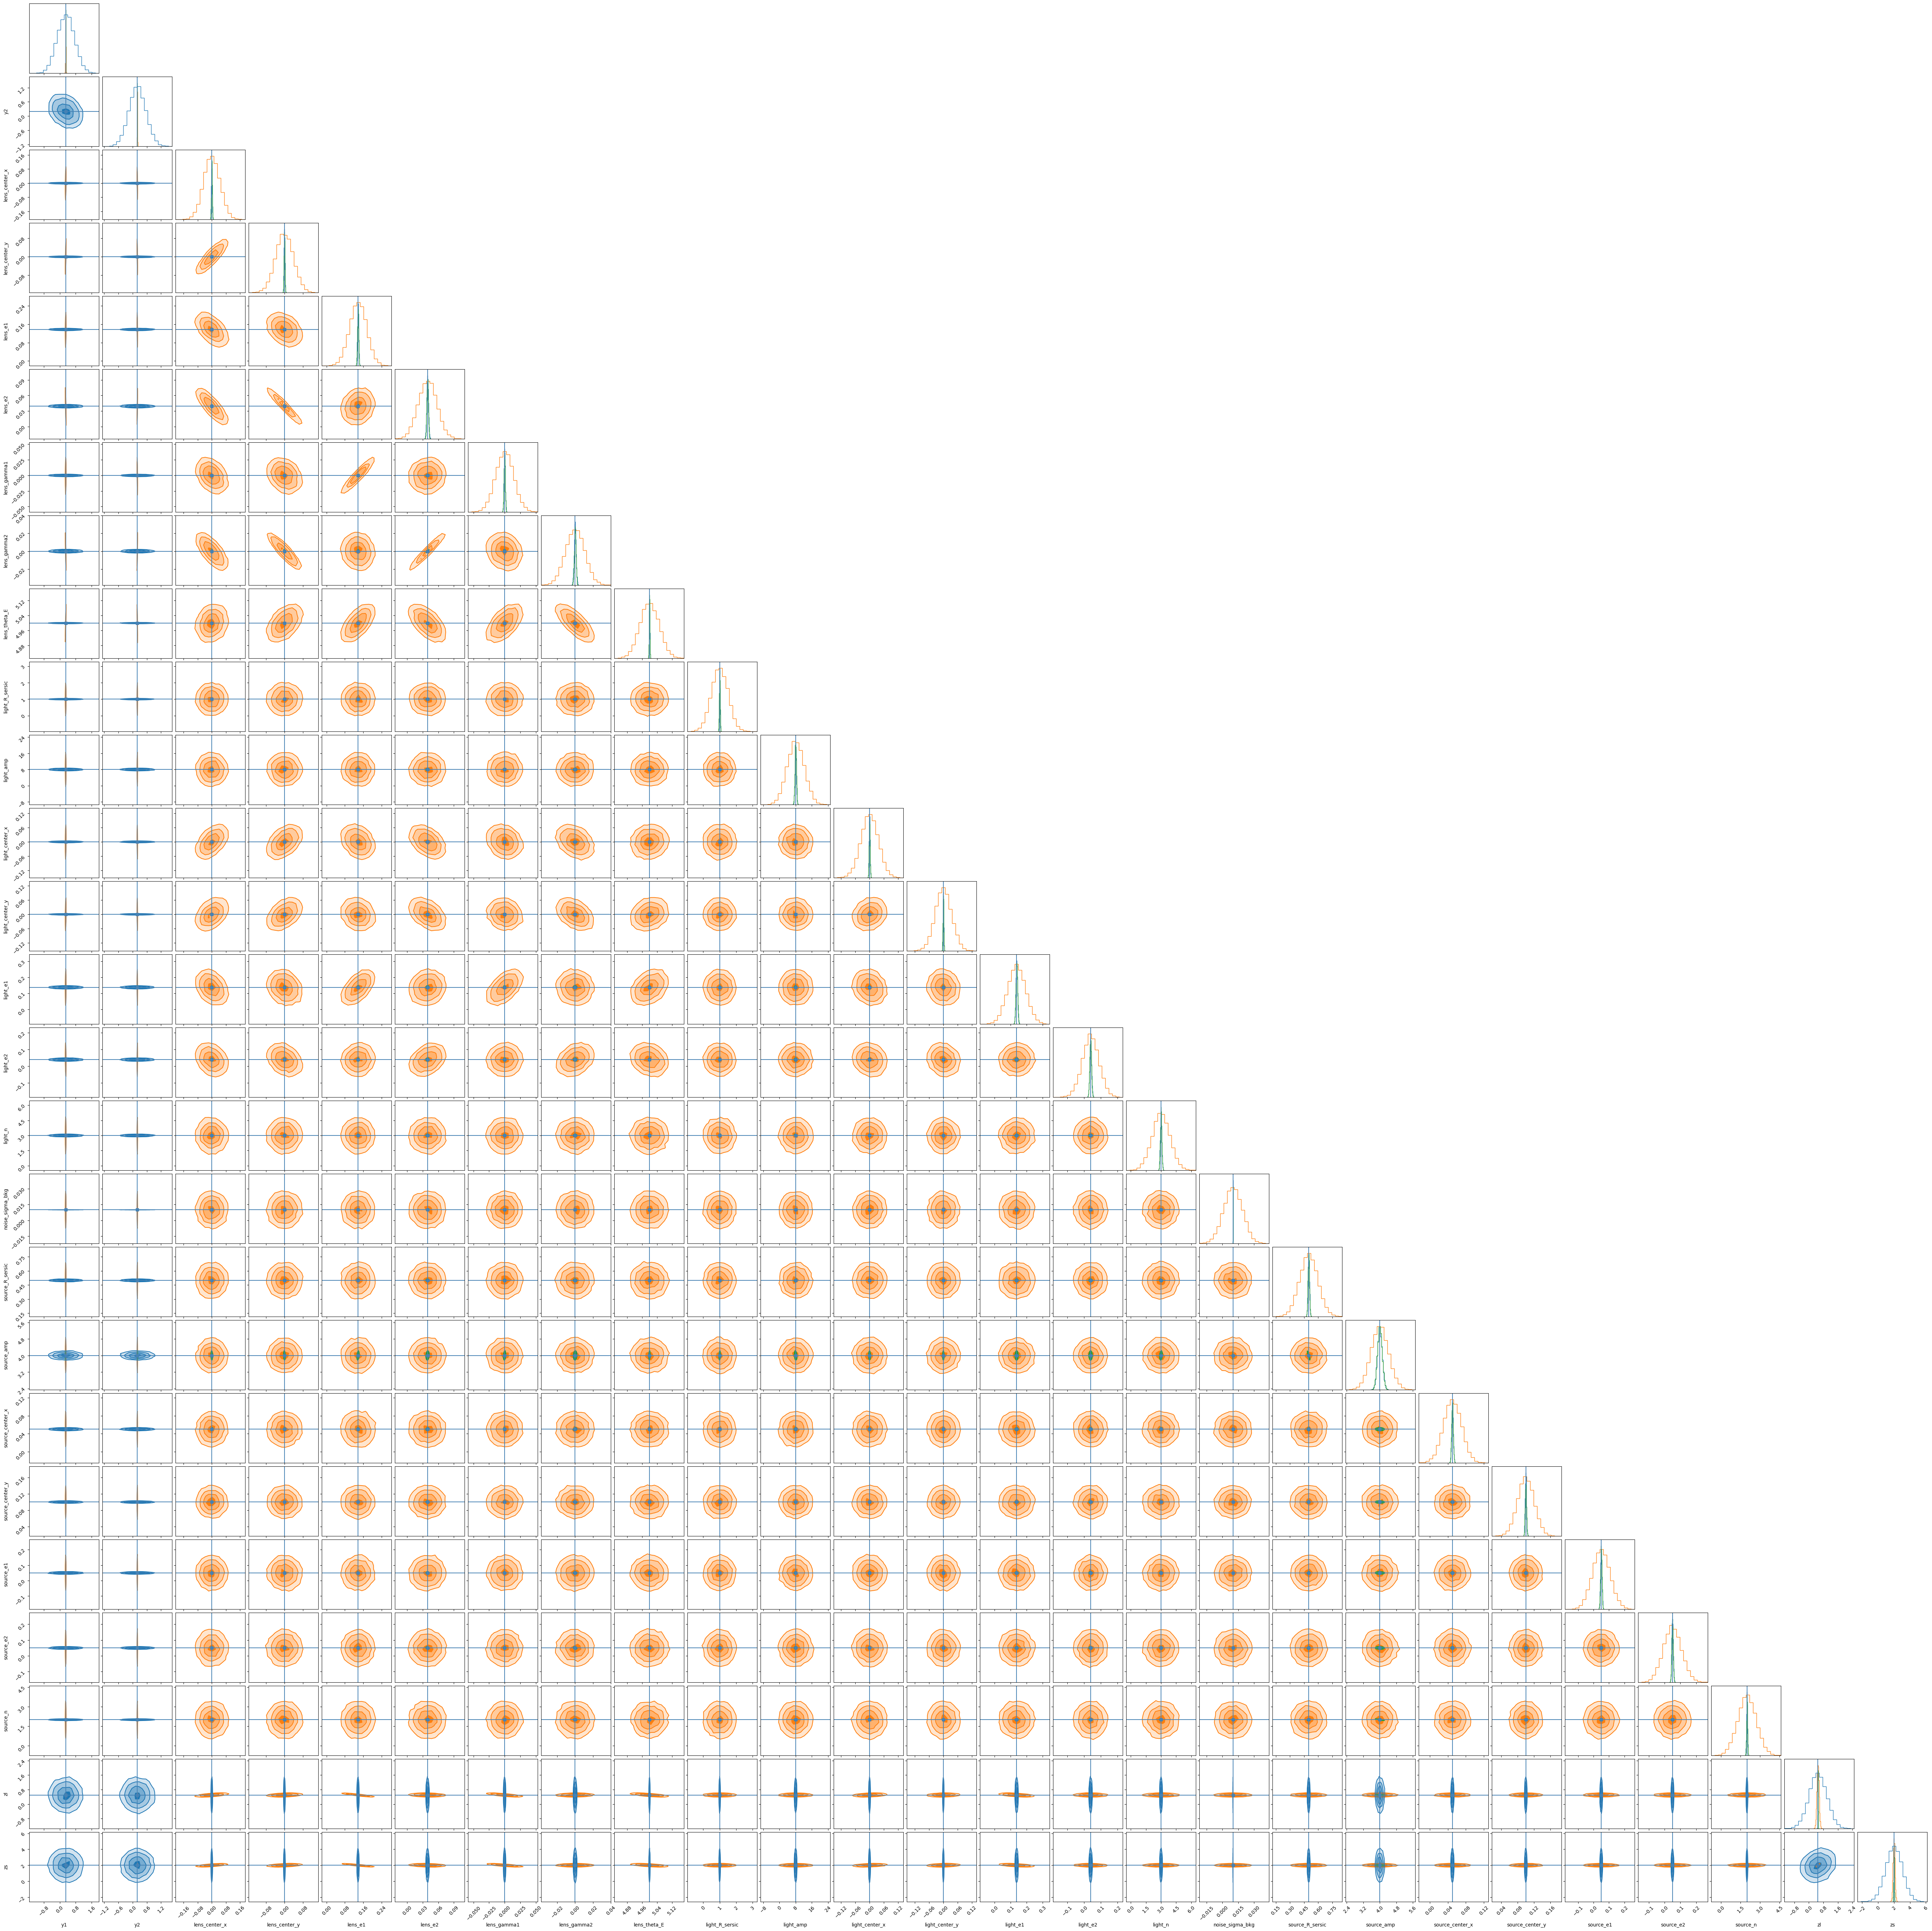

In [159]:
# Build corner plot
fig = None
fig = corner.corner(
    fim_samples_gw,
    color='tab:orange',
    labels=corner_labels,
    label_kwargs=dict(fontsize=10),
    fill_contours=True,
    plot_datapoints=False,
    hist_kwargs=dict(label="GW"),
    fig=fig,
)
fig = corner.corner(
    fim_samples_em,
    color='tab:blue',
    labels=corner_labels,
    label_kwargs=dict(fontsize=10),
    fill_contours=True,
    plot_datapoints=False,
    hist_kwargs=dict(label="EM"),
    fig=fig,
)

fig = corner.corner(
    fim_samples_gw_em,
    color='tab:green',
    labels=corner_labels,
    label_kwargs=dict(fontsize=10),
    fill_contours=True,
    plot_datapoints=False,
    hist_kwargs=dict(label="GW-EM"),
    truths=corner_truths,
    fig=fig,
)

    

In [184]:
# Select a consistent subset of variables as in the main script
var_names = [
    'lens_theta_E', 'zl', 'zs', 'lens_center_x', 'lens_center_y', 'source_center_x', 'source_center_y'
]
print(len(var_names))
# Helper to stack dict-like samples into ordered array
def stack_samples(sample_dict, keys):
    arr = np.column_stack([np.asarray(sample_dict[k]) for k in keys])
    return arr

# Prior samples: dict of arrays
prior_arr = stack_samples(prior_samples, var_names)
fisher_arr_gw = stack_samples(fim_samples_gw, var_names)
fisher_arr_em = stack_samples(fim_samples_em, var_names)
fisher_arr_gw_em = stack_samples(fim_samples_gw_em, var_names)

truths_sub = [input_params_splane_ord[k] for k in var_names]
print(len(truths_sub))

print(prior_arr.shape)
print(fisher_arr_gw.shape)  
print(fisher_arr_em.shape)
print(fisher_arr_gw_em.shape)

7
7
(3000, 7)
(20000, 7)
(20000, 7)
(20000, 7)


In [181]:
# # Build corner plot
# fig_sub = None
# # fig_sub = corner.corner(
# #     prior_arr,
# #     color='grey',
# #     labels=var_names,
# #     label_kwargs=dict(fontsize=10),
# #     fill_contours=True,
# #     plot_datapoints=False,
# #     hist_kwargs=dict(label="Prior"),
# #     fig=fig_sub,
# # )
# fig_sub = corner.corner(
#     fisher_arr_gw,
#     color='tab:orange',
#     labels=var_names,
#     label_kwargs=dict(fontsize=10),
#     fill_contours=True,
#     plot_datapoints=False,
#     hist_kwargs=dict(label="GW"),
#     fig=fig_sub,
# )

# fig_sub = corner.corner(
#     fisher_arr_em,
#     color='tab:blue',
#     labels=var_names,
#     label_kwargs=dict(fontsize=10),
#     fill_contours=True,
#     plot_datapoints=False,
#     hist_kwargs=dict(label="EM"),
#     truths=corner_truths,
#     fig=fig_sub,
# )

# fig_sub = corner.corner(
#     fisher_arr_gw_em,
#     color='tab:green',
#     labels=var_names,
#     label_kwargs=dict(fontsize=10),
#     fill_contours=True,
#     plot_datapoints=False,
#     hist_kwargs=dict(label="GW-EM"),
#     truths=truths_sub,
#     fig=fig_sub,
# )


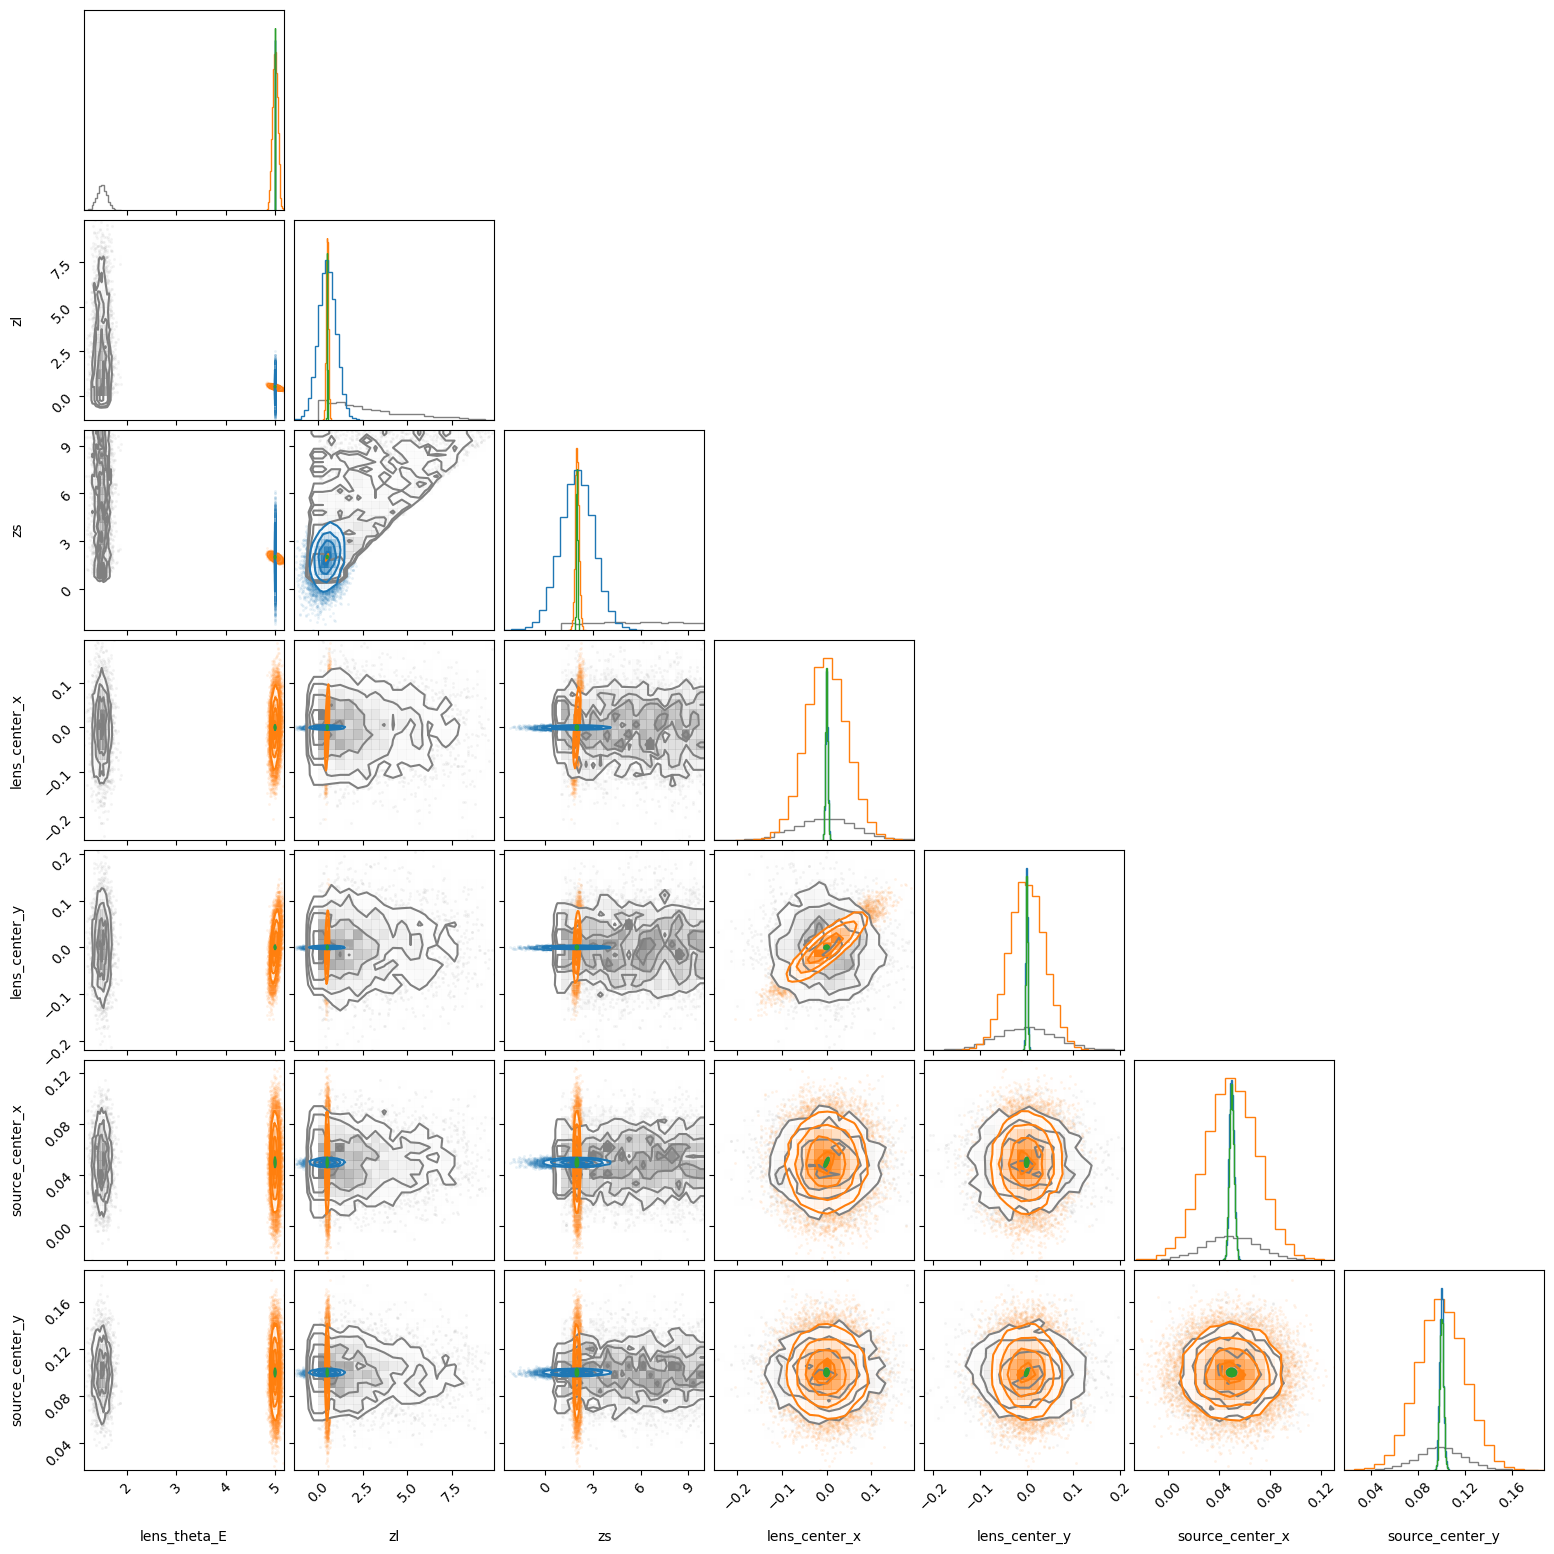

In [187]:
common_labels = var_names  # length 9
fig_common = corner.corner(prior_arr, labels=common_labels, color='grey')
fig_common = corner.corner(fisher_arr_gw,   labels=common_labels, color='tab:orange',fig=fig_common)
fig_common = corner.corner(fisher_arr_em,   labels=common_labels, color='tab:blue',  fig=fig_common)
fig_common = corner.corner(fisher_arr_gw_em, labels=common_labels, color='tab:green', fig=fig_common)

In [ ]:
def image_plane_to_source_plane(image_pos_flat):
    lens_params = kwargs_lens_true_sie_shear
    source_positions = []
    source_x = []
    source_y = []
    image_x = image_pos_flat[0:4]   
    image_y = image_pos_flat[4:8]
    for i in range(len(image_x)):
        source_ = lens_mass_model.ray_shooting(image_x[i], image_y[i], lens_params)
        source_positions.append(source_)
        source_x.append(source_[0])
        source_y.append(source_[1])
    source_x_ = jnp.array(source_x)
    source_y_ = jnp.array(source_y)
    source_x_sum = jnp.sum(source_x_)
    source_y_sum = jnp.sum(source_y_)

    return source_x_sum, source_y_sum

# Test the function with true image positions
true_image_pos_flat = jnp.array([
    x_image_true[0], x_image_true[1], x_image_true[2], x_image_true[3],
    y_image_true[0], y_image_true[1], y_image_true[2], y_image_true[3]
])
print("Test output (true image positions):", image_plane_to_source_plane(true_image_pos_flat))


In [ ]:
image_pos_flat = jnp.concatenate([x_image_true, y_image_true]) #[x1,x2,x3,x4,y1,y2,y3,y4]

In [ ]:
jac_yx = jax.jacfwd(image_plane_to_source_plane)(image_pos_flat)

# The Jacobian matrix jac_yx_matrix has the following structure:
# Let the outputs be:
#   ys1 = sum of source_x (i.e., source_x_sum)
#   ys2 = sum of source_y (i.e., source_y_sum)
#
# Let the inputs be:
#   x1, x2, x3, x4 = image_x1, image_x2, image_x3, image_x4
#   y1, y2, y3, y4 = image_y1, image_y2, image_y3, image_y4
#
# The Jacobian matrix entries are:
#   Row 1: [dys1/dx1, dys1/dx2, dys1/dx3, dys1/dx4, dys1/dy1, dys1/dy2, dys1/dy3, dys1/dy4]
#   Row 2: [dys2/dx1, dys2/dx2, dys2/dx3, dys2/dx4, dys2/dy1, dys2/dy2, dys2/dy3, dys2/dy4]
#

import pandas as pd
jac_yx_matrix = jnp.stack(jac_yx, axis=0)
input_labels = ['x1', 'x2', 'x3', 'x4', 'y1', 'y2', 'y3', 'y4']
output_labels = ['ys1', 'ys2']
jac_df = pd.DataFrame(jac_yx_matrix, index=output_labels, columns=input_labels)
print("Jacobian matrix (each entry is d(output)/d(input)):")
print(jac_df)


jac_xy_matrix = 1 / jac_yx_matrix.T
jac_xy_df = pd.DataFrame(jac_xy_matrix, index=input_labels, columns=output_labels)
print("Inverse Jacobian matrix (each entry is d(input)/d(output)):")
print(jac_xy_df)


In [ ]:
# Very simple stacking approach
print("=== VERY SIMPLE STACKING APPROACH ===")

JT_topleft = jac_xy_matrix 
print(f"   JT_topleft shape: {JT_topleft.shape}")

JT_topright = jnp.zeros((8, 24))
print(f"   JT_topright shape: {JT_topright.shape}")

JT_bottomleft = jnp.zeros((24, 2))
print(f"   JT_bottomleft shape: {JT_bottomleft.shape}")

JT_bottomright = jnp.eye(24)
print(f"   JT_bottomright shape: {JT_bottomright.shape}")


# Top half: [topleft, topright]
JT_top = jnp.hstack([JT_topleft, JT_topright])
print(f"   JT_top shape: {JT_top.shape}")

# Bottom half: [bottomleft, bottomright]
JT_bottom = jnp.hstack([JT_bottomleft, JT_bottomright])
print(f"   JT_bottom shape: {JT_bottom.shape}")

JT_full = jnp.vstack([JT_top, JT_bottom])
print(f"   JT_full shape: {JT_full.shape}")

# 4. Display the result
print(f"\n4. Final 32x26 Jacobian matrix:")

# Create labels
input_params = param_names_hessian
output_params = input_params_names_splane
# Create DataFrame
jac_df = pd.DataFrame(JT_full, index=input_params, columns=output_params)
print(jac_df)


In [ ]:
fisher_source = JT_full.T @ fisher_matrix @ JT_full
print(fisher_source.shape)
gw_em_cov_source = jnp.linalg.inv(fisher_source)
gw_em_cov_source.shape

In [ ]:
from collections import OrderedDict

# Create ordered dictionary with y1, y2 first
source_plane_params_ordered = OrderedDict([
    ('y1', y0true),
    ('y2', y1true),
    ('lens_center_x', input_params_constrained['lens_center_x']),
    ('lens_center_y', input_params_constrained['lens_center_y']),
    ('lens_e1', input_params_constrained['lens_e1']),
    ('lens_e2', input_params_constrained['lens_e2']),
    ('lens_gamma1', input_params_constrained['lens_gamma1']),
    ('lens_gamma2', input_params_constrained['lens_gamma2']),
    ('lens_theta_E', input_params_constrained['lens_theta_E']),
    ('light_R_sersic', input_params_constrained['light_R_sersic']),
    ('light_amp', input_params_constrained['light_amp']),
    ('light_center_x', input_params_constrained['light_center_x']),
    ('light_center_y', input_params_constrained['light_center_y']),
    ('light_e1', input_params_constrained['light_e1']),
    ('light_e2', input_params_constrained['light_e2']),
    ('light_n', input_params_constrained['light_n']),
    ('noise_sigma_bkg', input_params_constrained['noise_sigma_bkg']),
    ('source_R_sersic', input_params_constrained['source_R_sersic']),
    ('source_amp', input_params_constrained['source_amp']),
    ('source_center_x', input_params_constrained['source_center_x']),
    ('source_center_y', input_params_constrained['source_center_y']),
    ('source_e1', input_params_constrained['source_e1']),
    ('source_e2', input_params_constrained['source_e2']),
    ('source_n', input_params_constrained['source_n']),
    ('zl', input_params_constrained['zl']),
    ('zs', input_params_constrained['zs'])
])

# Create unravel function
splane_mean, splane_unravel_fn = jax.flatten_util.ravel_pytree(source_plane_params_ordered)

# Generate FIM samples
fim_samples = jax.vmap(splane_unravel_fn)(np.random.multivariate_normal(splane_mean, gw_em_cov_source, size=20000))

print(f"FIM samples with correct order: {list(fim_samples.keys())}")

In [ ]:
# import numpy as np
# # Generate samples from the posterior using Fisher matrix
# gw_mean, gw_unravel_fn = jax.flatten_util.ravel_pytree(gw_em_model.constrain(input_params_constrained))
# cov = cov_matrix
# # gw_cov_lhd_only = gw_cov_matrix_lhd_only
# fim_samples = jax.vmap(gw_unravel_fn)(np.random.multivariate_normal(gw_mean, cov, size=20000))
# # gw_fim_samples_lhd_only = jax.vmap(gw_unravel_fn)(np.random.multivariate_normal(gw_mean, gw_cov_lhd_only, size=5000000))



# print(f"Generated {len(fim_samples)} samples from GW-EM posterior")
# print(f"Sample shape: {fim_samples.keys()}")

In [ ]:
corner_label = list(fim_samples.keys())
corner_label

In [ ]:
# gw_true_constrained

In [ ]:
# true_params_flat

In [ ]:
fig = corner.corner(fim_samples, 
                    color='tab:orange', 
                    var_names=corner_label,
                    fill_contours=True,
                    plot_datapoints=False,
                    truths=splane_mean,
                    show_titles=True,
                    hist_kwargs=dict(label="GW-EM Fisher matrix estimate", linewidth=2))
fig.savefig("gw_em_fisher_corner.png")

In [ ]:
fig = corner.corner(fim_samples, 
                    color='tab:orange', 
                    var_names=corner_label,
                    fill_contours=True,
                    plot_datapoints=False,
                    truths=splane_mean,
                    show_titles=True,
                    title_limit=2,
                    hist_kwargs=dict(label="GW-EM Fisher matrix estimate", linewidth=2))
# fig.savefig("gw_em_fisher_corner.png")

In [ ]:
plt.hist(fim_samples['y2'])

In [ ]:
# Workaround for TracerArrayConversionError - ensure proper JAX array handling
from functools import partial
import jax
import jax.numpy as jnp
import herculens as hcl

class LensImageGW:
    """
    JAX/numpyro-compatible GW lensing utility with workaround for TracerArrayConversionError.
    Ensures all inputs are properly handled as JAX arrays.
    """

    def __init__(self, mass_model: hcl.MassModel):
        self.mass_model = mass_model

    def _ensure_jax_arrays(self, x, y):
        """Ensure x, y are JAX arrays, but only convert if needed."""
        # Only convert if they're not already JAX arrays
        if not isinstance(x, jnp.ndarray):
            x = jnp.asarray(x)
        if not isinstance(y, jnp.ndarray):
            y = jnp.asarray(y)
        return x, y

    @partial(jax.jit, static_argnums=(0,))
    def ray_shoot(self, x, y, kwargs_lens):
        x, y = self._ensure_jax_arrays(x, y)
        beta_x, beta_y = self.mass_model.ray_shooting(x, y, kwargs_lens)
        return beta_x, beta_y

    @partial(jax.jit, static_argnums=(0,))
    def potential(self, x, y, kwargs_lens):
        x, y = self._ensure_jax_arrays(x, y)
        return self.mass_model.potential(x, y, kwargs_lens)

    @partial(jax.jit, static_argnums=(0,))
    def magnification(self, x, y, kwargs_lens):
        x, y = self._ensure_jax_arrays(x, y)
        return self.mass_model.magnification(x, y, kwargs_lens)

    @partial(jax.jit, static_argnums=(0,))
    def fermat_potential(self, x, y, kwargs_lens, beta=None):
        x, y = self._ensure_jax_arrays(x, y)
        if beta is None:
            return self.mass_model.fermat_potential(x, y, kwargs_lens)
        beta_x, beta_y = beta
        # Ensure beta components are also JAX arrays
        if not isinstance(beta_x, jnp.ndarray):
            beta_x = jnp.asarray(beta_x)
        if not isinstance(beta_y, jnp.ndarray):
            beta_y = jnp.asarray(beta_y)
        return self.mass_model.fermat_potential(x, y, kwargs_lens, beta=(beta_x, beta_y))

    @partial(jax.jit, static_argnums=(0,))
    def time_delay(self, x, y, kwargs_lens, D_dt, beta=None):
        phi = self.fermat_potential(x, y, kwargs_lens, beta=beta)
        return D_dt * phi

    @partial(jax.jit, static_argnums=(0,))
    def compute(self, x, y, kwargs_lens, D_dt):
        """
        Convenience method returning a dict with ray-shooted source, potential,
        magnification, Fermat potential and time delay for given D_dt.
        """
        beta_x, beta_y = self.ray_shoot(x, y, kwargs_lens)
        psi = self.potential(x, y, kwargs_lens)
        mu = self.magnification(x, y, kwargs_lens)
        phi = self.fermat_potential(x, y, kwargs_lens, beta=(beta_x, beta_y))
        tau = D_dt * phi
        return {
            'beta_x': beta_x,
            'beta_y': beta_y,
            'psi': psi,
            'mu': mu,
            'phi': phi,
            'tau': tau,
        }

# Alternative: Non-JIT version for debugging
class LensImageGW_NoJIT:
    """
    Non-JIT version for debugging TracerArrayConversionError issues.
    Use this if the JIT version still fails.
    """
    
    def __init__(self, mass_model: hcl.MassModel):
        self.mass_model = mass_model

    def ray_shoot(self, x, y, kwargs_lens):
        x, y = jnp.asarray(x), jnp.asarray(y)
        beta_x, beta_y = self.mass_model.ray_shooting(x, y, kwargs_lens)
        return beta_x, beta_y

    def potential(self, x, y, kwargs_lens):
        x, y = jnp.asarray(x), jnp.asarray(y)
        return self.mass_model.potential(x, y, kwargs_lens)

    def magnification(self, x, y, kwargs_lens):
        x, y = jnp.asarray(x), jnp.asarray(y)
        return self.mass_model.magnification(x, y, kwargs_lens)

    def fermat_potential(self, x, y, kwargs_lens, beta=None):
        x, y = jnp.asarray(x), jnp.asarray(y)
        if beta is None:
            return self.mass_model.fermat_potential(x, y, kwargs_lens)
        beta_x, beta_y = beta
        beta_x, beta_y = jnp.asarray(beta_x), jnp.asarray(beta_y)
        return self.mass_model.fermat_potential(x, y, kwargs_lens, beta=(beta_x, beta_y))

    def time_delay(self, x, y, kwargs_lens, D_dt, beta=None):
        phi = self.fermat_potential(x, y, kwargs_lens, beta=beta)
        return D_dt * phi

    def compute(self, x, y, kwargs_lens, D_dt):
        beta_x, beta_y = self.ray_shoot(x, y, kwargs_lens)
        psi = self.potential(x, y, kwargs_lens)
        mu = self.magnification(x, y, kwargs_lens)
        phi = self.fermat_potential(x, y, kwargs_lens, beta=(beta_x, beta_y))
        tau = D_dt * phi
        return {
            'beta_x': beta_x,
            'beta_y': beta_y,
            'psi': psi,
            'mu': mu,
            'phi': phi,
            'tau': tau,
        }

# Test both versions
# mass_model = hcl.MassModel([hcl.SIE(), hcl.Shear()])
# 
# # Try JIT version first
# try:
#     lens_gw = LensImageGW(mass_model)
#     print("JIT version created successfully")
# except Exception as e:
#     print(f"JIT version failed: {e}")
#     # Fall back to non-JIT version
#     lens_gw = LensImageGW_NoJIT(mass_model)
#     print("Using non-JIT version")


In [ ]:
# Fixed LensImageGW class - removes jnp.asarray() calls that cause TracerArrayConversionError
from functools import partial
import jax
import jax.numpy as jnp
import herculens as hcl

class LensImageGW:
    """
    Fixed JAX/numpyro-compatible GW lensing utility.
    Removes jnp.asarray() calls that cause TracerArrayConversionError.
    """

    def __init__(self, mass_model: hcl.MassModel):
        self.mass_model = mass_model

    @partial(jax.jit, static_argnums=(0,))
    def ray_shoot(self, x, y, kwargs_lens):
        # Don't convert to array - x, y are already JAX arrays
        beta_x, beta_y = self.mass_model.ray_shooting(x, y, kwargs_lens)
        return beta_x, beta_y

    @partial(jax.jit, static_argnums=(0,))
    def potential(self, x, y, kwargs_lens):
        # Don't convert to array - x, y are already JAX arrays
        return self.mass_model.potential(x, y, kwargs_lens)

    @partial(jax.jit, static_argnums=(0,))
    def magnification(self, x, y, kwargs_lens):
        # Don't convert to array - x, y are already JAX arrays
        return self.mass_model.magnification(x, y, kwargs_lens)

    @partial(jax.jit, static_argnums=(0,))
    def fermat_potential(self, x, y, kwargs_lens, beta=None):
        # Don't convert to array - x, y are already JAX arrays
        if beta is None:
            return self.mass_model.fermat_potential(x, y, kwargs_lens)
        beta_x, beta_y = beta
        return self.mass_model.fermat_potential(x, y, kwargs_lens, beta=(beta_x, beta_y))

    @partial(jax.jit, static_argnums=(0,))
    def time_delay(self, x, y, kwargs_lens, D_dt, beta=None):
        phi = self.fermat_potential(x, y, kwargs_lens, beta=beta)
        return D_dt * phi

    @partial(jax.jit, static_argnums=(0,))
    def compute(self, x, y, kwargs_lens, D_dt):
        """
        Convenience method returning a dict with ray-shooted source, potential,
        magnification, Fermat potential and time delay for given D_dt.
        """
        beta_x, beta_y = self.ray_shoot(x, y, kwargs_lens)
        psi = self.potential(x, y, kwargs_lens)
        mu = self.magnification(x, y, kwargs_lens)
        phi = self.fermat_potential(x, y, kwargs_lens, beta=(beta_x, beta_y))
        tau = D_dt * phi
        return {
            'beta_x': beta_x,
            'beta_y': beta_y,
            'psi': psi,
            'mu': mu,
            'phi': phi,
            'tau': tau,
        }

# Test the fixed class
# mass_model = hcl.MassModel([hcl.SIE(), hcl.Shear()])
# lens_gw = LensImageGW(mass_model)
# 
# # Test with JAX arrays
# x_test = jnp.array([0.1, -0.1, 0.0])
# y_test = jnp.array([0.0, 0.0, 0.1])
# kwargs_test = [
#     {'theta_E': 1.5, 'e1': 0.1, 'e2': 0.05, 'center_x': 0.0, 'center_y': 0.0},
#     {'gamma1': 0.03, 'gamma2': 0.01, 'ra_0': 0.0, 'dec_0': 0.0}
# ]
# D_dt_test = 1.0
# 
# out = lens_gw.compute(x_test, y_test, kwargs_test, D_dt_test)
# print("Fixed class works!")


In [ ]:
# Finalized GW lensing helper for numpyro: init with MassModel only; pass D_dt per call
from functools import partial
import jax
import jax.numpy as jnp
import herculens as hcl

class LensImageGW:
    """
    Minimal JAX/numpyro-compatible wrapper around a provided herculens MassModel.
    Instantiate once outside your ProbModel with only the MassModel. Inside your
    probabilistic model, pass all inferred parameters (e.g., D_dt) as arguments
    to the methods. Uses herculens built-ins under the hood.

    Example usage:
      mass_model = hcl.MassModel([hcl.SIE(), hcl.Shear()])
      lens_gw = LensImageGW(mass_model)
      # inside ProbModel.model:
      # D_dt = numpyro.sample('D_dt', dist.LogNormal(...))
      # out = lens_gw.compute(x, y, kwargs_lens, D_dt)
    """

    def __init__(self, mass_model: hcl.MassModel):
        self.mass_model = mass_model

    @partial(jax.jit, static_argnums=(0,))
    def ray_shoot(self, x, y, kwargs_lens):
        x = jnp.asarray(x)
        y = jnp.asarray(y)
        beta_x, beta_y = self.mass_model.ray_shooting(x, y, kwargs_lens)
        return beta_x, beta_y

    @partial(jax.jit, static_argnums=(0,))
    def potential(self, x, y, kwargs_lens):
        x = jnp.asarray(x)
        y = jnp.asarray(y)
        return self.mass_model.potential(x, y, kwargs_lens)

    @partial(jax.jit, static_argnums=(0,))
    def magnification(self, x, y, kwargs_lens):
        x = jnp.asarray(x)
        y = jnp.asarray(y)
        return self.mass_model.magnification(x, y, kwargs_lens)

    @partial(jax.jit, static_argnums=(0,))
    def fermat_potential(self, x, y, kwargs_lens, beta=None):
        x = jnp.asarray(x)
        y = jnp.asarray(y)
        if beta is None:
            return self.mass_model.fermat_potential(x, y, kwargs_lens)
        beta_x, beta_y = beta
        return self.mass_model.fermat_potential(x, y, kwargs_lens,
                                                beta=(jnp.asarray(beta_x), jnp.asarray(beta_y)))

    @partial(jax.jit, static_argnums=(0,))
    def time_delay(self, x, y, kwargs_lens, D_dt, beta=None):
        phi = self.fermat_potential(x, y, kwargs_lens, beta=beta)
        return D_dt * phi

    @partial(jax.jit, static_argnums=(0,))
    def compute(self, x, y, kwargs_lens, D_dt):
        """
        Convenience method returning a dict with ray-shooted source, potential,
        magnification, Fermat potential and time delay for given D_dt.
        """
        beta_x, beta_y = self.ray_shoot(x, y, kwargs_lens)
        psi = self.potential(x, y, kwargs_lens)
        mu = self.magnification(x, y, kwargs_lens)
        phi = self.fermat_potential(x, y, kwargs_lens, beta=(beta_x, beta_y))
        tau = D_dt * phi
        return {
            'beta_x': beta_x,
            'beta_y': beta_y,
            'psi': psi,
            'mu': mu,
            'phi': phi,
            'tau': tau,
        }

# Notebook-side helper (commented):
# mass_model = hcl.MassModel([hcl.SIE(), hcl.Shear()])
# lens_gw = LensImageGW(mass_model)
# def gw_forward(x_images, y_images, kwargs_lens, D_dt):
#     out = lens_gw.compute(x_images, y_images, kwargs_lens, D_dt)
#     return out['tau'], out['mu']


In [ ]:
# Numpyro GW likelihood using LensImageGW
import numpyro
import numpyro.distributions as dist

def gw_likelihood_numpyro(lens_gw, image_positions, gw_observations, zl, zs):
    """
    Numpyro-compatible GW likelihood using LensImageGW.
    
    Args:
        lens_gw: LensImageGW instance (created outside)
        image_positions: list of (x, y) tuples in arcsec
        gw_observations: dict with 'time_delays', 'magnifications', 'dL_eff'
        zl, zs: lens and source redshifts
    """
    # Convert image positions to arrays
    x_images = jnp.array([pos[0] for pos in image_positions])
    y_images = jnp.array([pos[1] for pos in image_positions])
    n_images = len(image_positions)
    
    # Sample lens parameters (example - adjust priors as needed)
    lens_theta_E = numpyro.sample('lens_theta_E', dist.Normal(1.5, 0.1))
    lens_e1 = numpyro.sample('lens_e1', dist.TruncatedNormal(0.0, 0.1, low=-0.3, high=0.3))
    lens_e2 = numpyro.sample('lens_e2', dist.TruncatedNormal(0.0, 0.1, low=-0.3, high=0.3))
    lens_center_x = numpyro.sample('lens_center_x', dist.Normal(0.0, 0.01))
    lens_center_y = numpyro.sample('lens_center_y', dist.Normal(0.0, 0.01))
    lens_gamma1 = numpyro.sample('lens_gamma1', dist.TruncatedNormal(0.0, 0.1, low=-0.3, high=0.3))
    lens_gamma2 = numpyro.sample('lens_gamma2', dist.TruncatedNormal(0.0, 0.1, low=-0.3, high=0.3))
    
    # Sample D_dt (time delay distance scale)
    D_dt = numpyro.sample('D_dt', dist.LogNormal(0.0, 0.5))
    
    # Build kwargs_lens for herculens
    kwargs_lens = [
        {'theta_E': lens_theta_E, 'e1': lens_e1, 'e2': lens_e2, 
         'center_x': lens_center_x, 'center_y': lens_center_y},
        {'gamma1': lens_gamma1, 'gamma2': lens_gamma2, 'ra_0': 0.0, 'dec_0': 0.0}
    ]
    
    # Compute GW quantities using LensImageGW
    out = lens_gw.compute(x_images, y_images, kwargs_lens, D_dt)
    arrival_times = out['tau']
    magnifications = out['mu']
    
    # Sort by arrival time (earliest first)
    idx = jnp.argsort(arrival_times)
    sorted_arrival_times = arrival_times[idx]
    sorted_magnifications = magnifications[idx]
    
    # Compute effective luminosity distances
    dL = jax_cosmo.luminosity_distance(zs)
    dL_eff = dL / jnp.sqrt(jnp.abs(sorted_magnifications))
    
    # Time delay likelihood - each delay is independent observation
    if 'time_delays' in gw_observations:
        computed_delays = jnp.diff(sorted_arrival_times)
        obs_delays = jnp.array(gw_observations['time_delays'])
        sigma_td = jnp.array(gw_observations['time_delays']) * 0.05  # 5% error array
        
        # Each time delay is an independent observation (like pixels)
        numpyro.sample('time_delays', 
                      dist.Independent(dist.Normal(computed_delays, sigma_td), 1), 
                      obs=obs_delays)
    
    # Magnification likelihood
    if 'magnifications' in gw_observations:
        obs_mags = jnp.array(gw_observations['magnifications'])
        sigma_mag = 0.1 * jnp.abs(obs_mags)  # 10% error
        
        numpyro.sample('magnifications',
                      dist.Normal(sorted_magnifications, sigma_mag),
                      obs=obs_mags)
    
    # Effective luminosity distance likelihood
    if 'dL_eff' in gw_observations:
        obs_dL_eff = jnp.array(gw_observations['dL_eff'])
        sigma_dL = 0.05 * obs_dL_eff  # 5% error
        
        numpyro.sample('dL_eff',
                      dist.Normal(dL_eff, sigma_dL),
                      obs=obs_dL_eff)
    
    # Source position consistency (optional penalty)
    beta_x = out['beta_x']
    beta_y = out['beta_y']
    epsilon = 0.005
    consistency_penalty = -0.5 * jnp.sum(
        (jnp.diff(beta_x)**2 + jnp.diff(beta_y)**2) / (epsilon**2)
    )
    
    # Add consistency penalty as a deterministic variable
    numpyro.deterministic('consistency_penalty', consistency_penalty)

# Example usage (commented):
# mass_model = hcl.MassModel([hcl.SIE(), hcl.Shear()])
# lens_gw = LensImageGW(mass_model)
# 
# image_positions = [(0.1, 0.0), (-0.1, 0.0), (0.0, 0.1)]
# gw_observations = {
#     'time_delays': [1.2, 0.8],  # days
#     'magnifications': [2.1, 1.8, 0.9],
#     'dL_eff': [1000, 1200, 1500]  # Mpc
# }
# 
# # Use in your ProbModel
# def model():
#     gw_likelihood_numpyro(lens_gw, image_positions, gw_observations, zl=0.5, zs=2.0)
